1.  Combine all blocks into a single dataframe- keeping on relevant columns.
2. Use day-level energy consumption data per household to normalize data for inconsistent household count
3. Explore relationships between weather conditions and energy consumptions. Create clusters for the weather data- using which we can add weather identifiers to day-level data
4. Add UK holidays data to the day level data as an indicator.
5. Fit an ARIMA model
        i) ACF, PACF
        ii) Explore Seasonal Decomposition
        iii) Modelling 


# Daily Energy Data Preparation

**Importing Libraries **

In [1]:
import pandas as pd
import numpy as np
from pandas import datetime
from matplotlib import pyplot as plt
%matplotlib inline
import os
plt.style.use("ggplot")
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)


import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle'):
    for filename, j in zip(filenames, range(5)):
        print(os.path.join(dirname, filename))

/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/input/smart-meters-in-london/daily_dataset.csv.gz
/kaggle/input/smart-meters-in-london/weather_daily_darksky.csv
/kaggle/input/smart-meters-in-london/hhblock_dataset.zip
/kaggle/input/smart-meters-in-london/acorn_details.csv
/kaggle/input/smart-meters-in-london/uk_bank_holidays.csv
/kaggle/input/smart-meters-in-london/daily_dataset.csv/daily_dataset.csv
/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset/block_99.csv
/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset/block_37.csv
/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset/block_69.csv
/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset/block_39.csv
/kaggle/input/smart-meters-in-london/halfhourly_dataset/halfhourly_dataset/block_96.csv
/kaggle/input/smart-meters-in-london/daily_dataset/daily_dataset/block_99.csv
/kaggle/input/smart-meters-in-london/daily_dataset/daily_dataset/bl

### Energy Data

> We are predicting for energy demand in the future- therefore we are taking only energy sum i.e. total energy use per day for a given household.

In [3]:
# Combining all blocks
df = pd.DataFrame()
for num in range(0,112):
    df_unit = pd.read_csv("/kaggle/input/smart-meters-in-london/hhblock_dataset/hhblock_dataset/block_"+str(num)+".csv")
    df_unit["energy_sum"] = df_unit.drop(["LCLid", "day"], axis=1).sum(axis=1)
    df_unit = df_unit[['day','LCLid','energy_sum']]
    df_unit.reset_index()
    #df.to_csv("hc_"+str(num)+".csv")
    df = pd.concat([df, df_unit], axis=0)

In [4]:
df.to_csv("energy.csv", index=False)

### ** Energy at Day Level **

In [5]:
energy = pd.read_csv('/kaggle/working/energy.csv')

In [6]:
len(energy)

3469352

In [7]:
energy.head(5)

day      LCLid  energy_sum
0  2012-10-13  MAC000002      11.087
1  2012-10-14  MAC000002      13.223
2  2012-10-15  MAC000002      10.257
3  2012-10-16  MAC000002       9.769
4  2012-10-17  MAC000002      10.885

In [8]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3469352 entries, 0 to 3469351
Data columns (total 3 columns):
day           object
LCLid         object
energy_sum    float64
dtypes: float64(1), object(2)
memory usage: 79.4+ MB


**House Count**
> In the dataset we see that the number of households for which energy data was collected across different days are different. This is probably due to the gradually increasing adoption of smart meters in London.  This could lead to false interpretation that the energy for a particular day might be high when it could be that the data was only collected for more number of houses. We will look at the house count for each day.  

In [9]:
housecount = energy.groupby('day')[['LCLid']].nunique()

In [10]:
housecount.rename(columns={"LCLid": "HouseCount"}, inplace=True)
#housecount.columns = ["HouseCount"]

In [11]:
housecount.head(7)

HouseCount
day                   
2011-11-24          13
2011-11-25          25
2011-11-26          32
2011-11-27          41
2011-11-28          41
2011-11-29          55
2011-11-30          63

In [12]:
len(housecount)

827

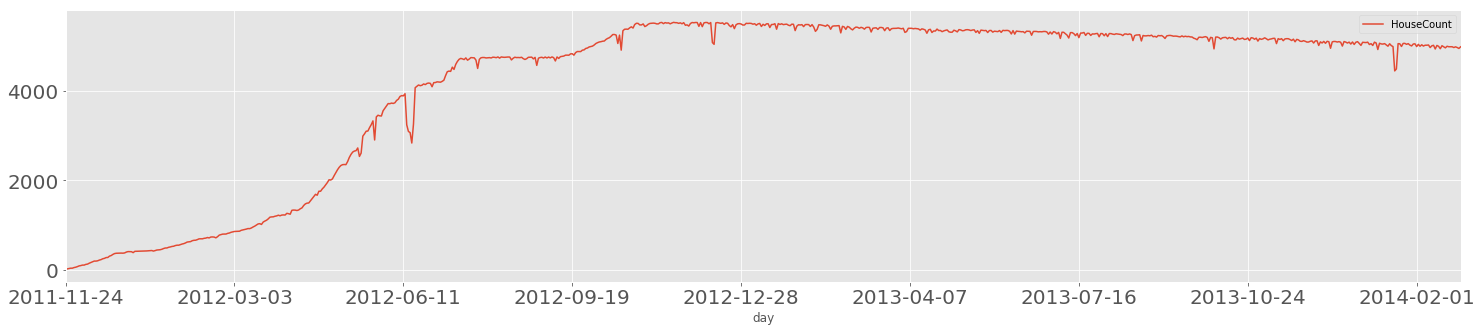

In [13]:
housecount.plot(figsize=(25,5))

**Normalization across households**
> The data collection across households are inconsistent- therefore we will be using *energy per household* as the target to predict rather than energy alone. This is an optional step as we can also predict for energy sum as whole for each household. However there are quite a lot of unique households for which we have to repeat the exercise and our ultimate goal is to predict overall consumption forecast and not at household level.  
This also means that since household level is removed, we are not looking into the ACORN details which is available at household level

In [14]:
energy_per_house = energy.groupby('day')[['energy_sum']].sum()
energy_per_house = energy_per_house.merge(housecount, on = ['day'])
energy_per_house = energy_per_house.reset_index()

In [15]:
energy_per_house.head(5)

day  energy_sum  HouseCount
0  2011-11-24  139.472000          13
1  2011-11-25  254.555000          25
2  2011-11-26  339.542000          32
3  2011-11-27  444.883001          41
4  2011-11-28  414.328000          41

In [16]:
energy_per_house.count()

day           827
energy_sum    827
HouseCount    827
dtype: int64

In [17]:
energy_per_house.day = pd.to_datetime(energy_per_house.day,format='%Y-%m-%d').dt.date

In [18]:
energy_per_house.head(5)

day  energy_sum  HouseCount
0  2011-11-24  139.472000          13
1  2011-11-25  254.555000          25
2  2011-11-26  339.542000          32
3  2011-11-27  444.883001          41
4  2011-11-28  414.328000          41

In [19]:
energy_per_house['avg_energy'] =  energy_per_house['energy_sum']/energy_per_house['HouseCount']
print("Starting Point of Data at Day Level",min(energy_per_house.day))
print("Ending Point of Data at Day Level",max(energy_per_house.day))

Starting Point of Data at Day Level 2011-11-24
Ending Point of Data at Day Level 2014-02-27


In [20]:
energy_per_house.head(5)

day  energy_sum  HouseCount  avg_energy
0  2011-11-24  139.472000          13   10.728615
1  2011-11-25  254.555000          25   10.182200
2  2011-11-26  339.542000          32   10.610687
3  2011-11-27  444.883001          41   10.850805
4  2011-11-28  414.328000          41   10.105561

In [21]:
energy_per_house.describe()

energy_sum   HouseCount  avg_energy
count    827.000000   827.000000  827.000000
mean   42640.567599  4195.105200   10.416972
std    19988.577985  1781.167569    1.852431
min      139.472000    13.000000    7.636806
25%    34310.153500  4000.000000    8.595344
50%    45574.833993  5102.000000   10.422188
75%    58565.693502  5332.000000   11.867897
max    82378.634002  5525.000000   15.946065

In [22]:
energy_per_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827 entries, 0 to 826
Data columns (total 4 columns):
day           827 non-null object
energy_sum    827 non-null float64
HouseCount    827 non-null int64
avg_energy    827 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 26.0+ KB


## Weather Information
Daily level weather information is taken using darksky api in the dataset[](http://)

In [23]:
weather = pd.read_csv('/kaggle/input/smart-meters-in-london/weather_daily_darksky.csv')
weather.head(4)

temperatureMax   temperatureMaxTime  windBearing               icon  \
0           11.96  2011-11-11 23:00:00          123                fog   
1            8.59  2011-12-11 14:00:00          198  partly-cloudy-day   
2           10.33  2011-12-27 02:00:00          225  partly-cloudy-day   
3            8.07  2011-12-02 23:00:00          232               wind   

   dewPoint   temperatureMinTime  cloudCover  windSpeed  pressure  \
0      9.40  2011-11-11 07:00:00        0.79       3.88   1016.08   
1      4.49  2011-12-11 01:00:00        0.56       3.94   1007.71   
2      5.47  2011-12-27 23:00:00        0.85       3.54   1032.76   
3      3.69  2011-12-02 07:00:00        0.32       3.00   1012.12   

  apparentTemperatureMinTime  ...  temperatureHigh          sunriseTime  \
0        2011-11-11 07:00:00  ...            10.87  2011-11-11 07:12:14   
1        2011-12-11 02:00:00  ...             8.59  2011-12-11 07:57:02   
2        2011-12-27 22:00:00  ...            10.33  2011-12-27 08:07:06   
3        2011-12-02 07:00:00  ...             7.36  2011-12-02 07:46:09   

   temperatureHighTime          uvIndexTime  \
0  2011-11-11 19:00:00  2011-11-11 11:00:00   
1  2011-12-11 14:00:00  2011-12-11 12:00:00   
2  2011-12-27 14:00:00  2011-12-27 00:00:00   
3  2011-12-02 12:00:00  2011-12-02 10:00:00   

                                             summary   temperatureLowTime  \
0                             Foggy until afternoon.  2011-11-11 19:00:00   
1                  Partly cloudy throughout the day.  2011-12-12 07:00:00   
2                  Mostly cloudy throughout the day.  2011-12-27 23:00:00   
3  Partly cloudy throughout the day and breezy ov...  2011-12-02 19:00:00   

   apparentTemperatureMin  apparentTemperatureMaxTime  \
0                    6.48         2011-11-11 23:00:00   
1                    0.11         2011-12-11 20:00:00   
2                    5.59         2011-12-27 02:00:00   
3                    0.46         2011-12-02 12:00:00   

  apparentTemperatureLowTime moonPhase  
0        2011-11-11 19:00:00      0.52  
1        2011-12-12 08:00:00      0.53  
2        2011-12-28 00:00:00      0.10  
3        2011-12-02 19:00:00      0.25  

[4 rows x 32 columns]

In [24]:
weather.describe()

temperatureMax  windBearing    dewPoint  cloudCover   windSpeed  \
count      882.000000   882.000000  882.000000  881.000000  882.000000   
mean        13.660113   195.702948    6.530034    0.477605    3.581803   
std          6.182744    89.340783    4.830875    0.193514    1.694007   
min         -0.060000     0.000000   -7.840000    0.000000    0.200000   
25%          9.502500   120.500000    3.180000    0.350000    2.370000   
50%         12.625000   219.000000    6.380000    0.470000    3.440000   
75%         17.920000   255.000000   10.057500    0.600000    4.577500   
max         32.400000   359.000000   17.770000    1.000000    9.960000   

          pressure  apparentTemperatureHigh  visibility    humidity  \
count   882.000000               882.000000  882.000000  882.000000   
mean   1014.127540                12.723866   11.167143    0.781871   
std      11.073038                 7.279168    2.466109    0.095348   
min     979.250000                -6.460000    1.480000    0.430000   
25%    1007.435000                 7.032500   10.327500    0.720000   
50%    1014.615000                12.470000   11.970000    0.790000   
75%    1021.755000                17.910000   12.830000    0.860000   
max    1040.920000                32.420000   15.340000    0.980000   

       apparentTemperatureLow  apparentTemperatureMax     uvIndex  \
count              882.000000              882.000000  881.000000   
mean                 6.085045               12.929467    2.542565   
std                  6.031967                7.105426    1.832985   
min                 -8.880000               -4.110000    0.000000   
25%                  1.522500                7.332500    1.000000   
50%                  5.315000               12.625000    2.000000   
75%                 11.467500               17.920000    4.000000   
max                 20.540000               32.420000    7.000000   

       temperatureLow  temperatureMin  temperatureHigh  \
count      882.000000      882.000000       882.000000   
mean         7.709841        7.414161        13.542392   
std          4.871004        4.888852         6.260196   
min         -5.640000       -5.640000        -0.810000   
25%          3.990000        3.705000         9.212500   
50%          7.540000        7.100000        12.470000   
75%         11.467500       11.277500        17.910000   
max         20.540000       20.540000        32.400000   

       apparentTemperatureMin   moonPhase  
count              882.000000  882.000000  
mean                 5.738039    0.500930  
std                  6.048746    0.287022  
min                 -8.880000    0.000000  
25%                  1.105000    0.260000  
50%                  4.885000    0.500000  
75%                 11.277500    0.750000  
max                 20.540000    0.990000

In [25]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 32 columns):
temperatureMax                 882 non-null float64
temperatureMaxTime             882 non-null object
windBearing                    882 non-null int64
icon                           882 non-null object
dewPoint                       882 non-null float64
temperatureMinTime             882 non-null object
cloudCover                     881 non-null float64
windSpeed                      882 non-null float64
pressure                       882 non-null float64
apparentTemperatureMinTime     882 non-null object
apparentTemperatureHigh        882 non-null float64
precipType                     882 non-null object
visibility                     882 non-null float64
humidity                       882 non-null float64
apparentTemperatureHighTime    882 non-null object
apparentTemperatureLow         882 non-null float64
apparentTemperatureMax         882 non-null float64
uvIndex            

In [26]:
weather['day']=  pd.to_datetime(weather['time']) # day is given as timestamp
weather['day']=  pd.to_datetime(weather['day'],format='%Y%m%d').dt.date

In [27]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882 entries, 0 to 881
Data columns (total 33 columns):
temperatureMax                 882 non-null float64
temperatureMaxTime             882 non-null object
windBearing                    882 non-null int64
icon                           882 non-null object
dewPoint                       882 non-null float64
temperatureMinTime             882 non-null object
cloudCover                     881 non-null float64
windSpeed                      882 non-null float64
pressure                       882 non-null float64
apparentTemperatureMinTime     882 non-null object
apparentTemperatureHigh        882 non-null float64
precipType                     882 non-null object
visibility                     882 non-null float64
humidity                       882 non-null float64
apparentTemperatureHighTime    882 non-null object
apparentTemperatureLow         882 non-null float64
apparentTemperatureMax         882 non-null float64
uvIndex            

In [28]:
weather.head()

temperatureMax   temperatureMaxTime  windBearing                 icon  \
0           11.96  2011-11-11 23:00:00          123                  fog   
1            8.59  2011-12-11 14:00:00          198    partly-cloudy-day   
2           10.33  2011-12-27 02:00:00          225    partly-cloudy-day   
3            8.07  2011-12-02 23:00:00          232                 wind   
4            8.22  2011-12-24 23:00:00          252  partly-cloudy-night   

   dewPoint   temperatureMinTime  cloudCover  windSpeed  pressure  \
0      9.40  2011-11-11 07:00:00        0.79       3.88   1016.08   
1      4.49  2011-12-11 01:00:00        0.56       3.94   1007.71   
2      5.47  2011-12-27 23:00:00        0.85       3.54   1032.76   
3      3.69  2011-12-02 07:00:00        0.32       3.00   1012.12   
4      2.79  2011-12-24 07:00:00        0.37       4.46   1028.17   

  apparentTemperatureMinTime  ...          sunriseTime  temperatureHighTime  \
0        2011-11-11 07:00:00  ...  2011-11-11 07:12:14  2011-11-11 19:00:00   
1        2011-12-11 02:00:00  ...  2011-12-11 07:57:02  2011-12-11 14:00:00   
2        2011-12-27 22:00:00  ...  2011-12-27 08:07:06  2011-12-27 14:00:00   
3        2011-12-02 07:00:00  ...  2011-12-02 07:46:09  2011-12-02 12:00:00   
4        2011-12-24 07:00:00  ...  2011-12-24 08:06:15  2011-12-24 15:00:00   

           uvIndexTime                                            summary  \
0  2011-11-11 11:00:00                             Foggy until afternoon.   
1  2011-12-11 12:00:00                  Partly cloudy throughout the day.   
2  2011-12-27 00:00:00                  Mostly cloudy throughout the day.   
3  2011-12-02 10:00:00  Partly cloudy throughout the day and breezy ov...   
4  2011-12-24 13:00:00                  Mostly cloudy throughout the day.   

    temperatureLowTime  apparentTemperatureMin  apparentTemperatureMaxTime  \
0  2011-11-11 19:00:00                    6.48         2011-11-11 23:00:00   
1  2011-12-12 07:00:00                    0.11         2011-12-11 20:00:00   
2  2011-12-27 23:00:00                    5.59         2011-12-27 02:00:00   
3  2011-12-02 19:00:00                    0.46         2011-12-02 12:00:00   
4  2011-12-24 19:00:00                   -0.51         2011-12-24 23:00:00   

   apparentTemperatureLowTime moonPhase         day  
0         2011-11-11 19:00:00      0.52  2011-11-11  
1         2011-12-12 08:00:00      0.53  2011-12-11  
2         2011-12-28 00:00:00      0.10  2011-12-27  
3         2011-12-02 19:00:00      0.25  2011-12-02  
4         2011-12-24 20:00:00      0.99  2011-12-24  

[5 rows x 33 columns]

In [29]:
weather.columns

Index(['temperatureMax', 'temperatureMaxTime', 'windBearing', 'icon',
       'dewPoint', 'temperatureMinTime', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureMinTime', 'apparentTemperatureHigh', 'precipType',
       'visibility', 'humidity', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex', 'time',
       'sunsetTime', 'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'sunriseTime', 'temperatureHighTime', 'uvIndexTime', 'summary',
       'temperatureLowTime', 'apparentTemperatureMin',
       'apparentTemperatureMaxTime', 'apparentTemperatureLowTime', 'moonPhase',
       'day'],
      dtype='object')

In [30]:
weather.head()

temperatureMax   temperatureMaxTime  windBearing                 icon  \
0           11.96  2011-11-11 23:00:00          123                  fog   
1            8.59  2011-12-11 14:00:00          198    partly-cloudy-day   
2           10.33  2011-12-27 02:00:00          225    partly-cloudy-day   
3            8.07  2011-12-02 23:00:00          232                 wind   
4            8.22  2011-12-24 23:00:00          252  partly-cloudy-night   

   dewPoint   temperatureMinTime  cloudCover  windSpeed  pressure  \
0      9.40  2011-11-11 07:00:00        0.79       3.88   1016.08   
1      4.49  2011-12-11 01:00:00        0.56       3.94   1007.71   
2      5.47  2011-12-27 23:00:00        0.85       3.54   1032.76   
3      3.69  2011-12-02 07:00:00        0.32       3.00   1012.12   
4      2.79  2011-12-24 07:00:00        0.37       4.46   1028.17   

  apparentTemperatureMinTime  ...          sunriseTime  temperatureHighTime  \
0        2011-11-11 07:00:00  ...  2011-11-11 07:12:14  2011-11-11 19:00:00   
1        2011-12-11 02:00:00  ...  2011-12-11 07:57:02  2011-12-11 14:00:00   
2        2011-12-27 22:00:00  ...  2011-12-27 08:07:06  2011-12-27 14:00:00   
3        2011-12-02 07:00:00  ...  2011-12-02 07:46:09  2011-12-02 12:00:00   
4        2011-12-24 07:00:00  ...  2011-12-24 08:06:15  2011-12-24 15:00:00   

           uvIndexTime                                            summary  \
0  2011-11-11 11:00:00                             Foggy until afternoon.   
1  2011-12-11 12:00:00                  Partly cloudy throughout the day.   
2  2011-12-27 00:00:00                  Mostly cloudy throughout the day.   
3  2011-12-02 10:00:00  Partly cloudy throughout the day and breezy ov...   
4  2011-12-24 13:00:00                  Mostly cloudy throughout the day.   

    temperatureLowTime  apparentTemperatureMin  apparentTemperatureMaxTime  \
0  2011-11-11 19:00:00                    6.48         2011-11-11 23:00:00   
1  2011-12-12 07:00:00                    0.11         2011-12-11 20:00:00   
2  2011-12-27 23:00:00                    5.59         2011-12-27 02:00:00   
3  2011-12-02 19:00:00                    0.46         2011-12-02 12:00:00   
4  2011-12-24 19:00:00                   -0.51         2011-12-24 23:00:00   

   apparentTemperatureLowTime moonPhase         day  
0         2011-11-11 19:00:00      0.52  2011-11-11  
1         2011-12-12 08:00:00      0.53  2011-12-11  
2         2011-12-28 00:00:00      0.10  2011-12-27  
3         2011-12-02 19:00:00      0.25  2011-12-02  
4         2011-12-24 20:00:00      0.99  2011-12-24  

[5 rows x 33 columns]

In [31]:
# selecting numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]
weather = weather.dropna()

In [32]:
weather.describe()

temperatureMax  windBearing    dewPoint  cloudCover   windSpeed  \
count      881.000000   881.000000  881.000000  881.000000  881.000000   
mean        13.662747   195.712826    6.529750    0.477605    3.577696   
std          6.185761    89.391048    4.833612    0.193514    1.690570   
min         -0.060000     0.000000   -7.840000    0.000000    0.200000   
25%          9.490000   120.000000    3.180000    0.350000    2.370000   
50%         12.630000   219.000000    6.370000    0.470000    3.440000   
75%         17.920000   255.000000   10.060000    0.600000    4.570000   
max         32.400000   359.000000   17.770000    1.000000    9.960000   

          pressure  apparentTemperatureHigh  visibility    humidity  \
count   881.000000               881.000000  881.000000  881.000000   
mean   1014.151158                12.726016   11.168524    0.781782   
std      11.057077                 7.283022    2.467169    0.095366   
min     979.250000                -6.460000    1.480000    0.430000   
25%    1007.450000                 7.030000   10.350000    0.720000   
50%    1014.620000                12.480000   11.970000    0.790000   
75%    1021.760000                17.920000   12.830000    0.860000   
max    1040.920000                32.420000   15.340000    0.980000   

       apparentTemperatureLow  apparentTemperatureMax     uvIndex  \
count              881.000000              881.000000  881.000000   
mean                 6.088138               12.931271    2.542565   
std                  6.034694                7.109260    1.832985   
min                 -8.880000               -4.110000    0.000000   
25%                  1.510000                7.330000    1.000000   
50%                  5.320000               12.630000    2.000000   
75%                 11.470000               17.920000    4.000000   
max                 20.540000               32.420000    7.000000   

       temperatureLow  temperatureMin  temperatureHigh  \
count      881.000000      881.000000       881.000000   
mean         7.711169        7.415096        13.545471   
std          4.873611        4.891550         6.263084   
min         -5.640000       -5.640000        -0.810000   
25%          3.980000        3.700000         9.210000   
50%          7.540000        7.100000        12.480000   
75%         11.470000       11.280000        17.920000   
max         20.540000       20.540000        32.400000   

       apparentTemperatureMin   moonPhase  
count              881.000000  881.000000  
mean                 5.740942    0.501487  
std                  6.051567    0.286707  
min                 -8.880000    0.000000  
25%                  1.100000    0.260000  
50%                  4.890000    0.500000  
75%                 11.280000    0.750000  
max                 20.540000    0.990000

### Relationship of weather conditions with electricity consumption

In [33]:
weather_energy =  energy_per_house.merge(weather,on='day')
weather_energy.head(2)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-24     139.472          13   10.728615           12.93   
1  2011-11-25     254.555          25   10.182200           13.03   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  visibility  \
0          204      8.56        0.41       4.04   1027.22  ...       10.64   
1          243      7.24        0.48       5.02   1024.47  ...       12.38   

   humidity  apparentTemperatureLow  apparentTemperatureMax  uvIndex  \
0      0.89                    7.30                   12.93      1.0   
1      0.79                    4.69                   13.03      1.0   

   temperatureLow  temperatureMin  temperatureHigh  apparentTemperatureMin  \
0            9.71            8.56            12.93                    7.01   
1            7.01            7.46            12.27                    4.84   

   moonPhase  
0       0.97  
1       0.01  

[2 rows x 21 columns]

In [34]:
len(weather_energy)

826

In [35]:
weather_energy.head(3)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-24     139.472          13   10.728615           12.93   
1  2011-11-25     254.555          25   10.182200           13.03   
2  2011-11-26     339.542          32   10.610687           12.96   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  visibility  \
0          204      8.56        0.41       4.04   1027.22  ...       10.64   
1          243      7.24        0.48       5.02   1024.47  ...       12.38   
2          237      6.96        0.44       5.75   1025.80  ...       13.07   

   humidity  apparentTemperatureLow  apparentTemperatureMax  uvIndex  \
0      0.89                    7.30                   12.93      1.0   
1      0.79                    4.69                   13.03      1.0   
2      0.81                   11.59                   12.96      1.0   

   temperatureLow  temperatureMin  temperatureHigh  apparentTemperatureMin  \
0            9.71            8.56            12.93                    7.01   
1            7.01            7.46            12.27                    4.84   
2           11.59            7.01            12.96                    4.69   

   moonPhase  
0       0.97  
1       0.01  
2       0.05  

[3 rows x 21 columns]

In [36]:
weather_energy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 826 entries, 0 to 825
Data columns (total 21 columns):
day                        826 non-null object
energy_sum                 826 non-null float64
HouseCount                 826 non-null int64
avg_energy                 826 non-null float64
temperatureMax             826 non-null float64
windBearing                826 non-null int64
dewPoint                   826 non-null float64
cloudCover                 826 non-null float64
windSpeed                  826 non-null float64
pressure                   826 non-null float64
apparentTemperatureHigh    826 non-null float64
visibility                 826 non-null float64
humidity                   826 non-null float64
apparentTemperatureLow     826 non-null float64
apparentTemperatureMax     826 non-null float64
uvIndex                    826 non-null float64
temperatureLow             826 non-null float64
temperatureMin             826 non-null float64
temperatureHigh            826 non-n

In [37]:
weather_energy.to_csv("weather_energy.csv",index=False)

 *** 1. Temperature ***
> We can see that energy and temperature have an inverse relationship-we can see the peaks in one appearing with troughs in the other. This confirms the business intuition that during low temperature, it is likely that the energy consumption through heaters etc. increases. 

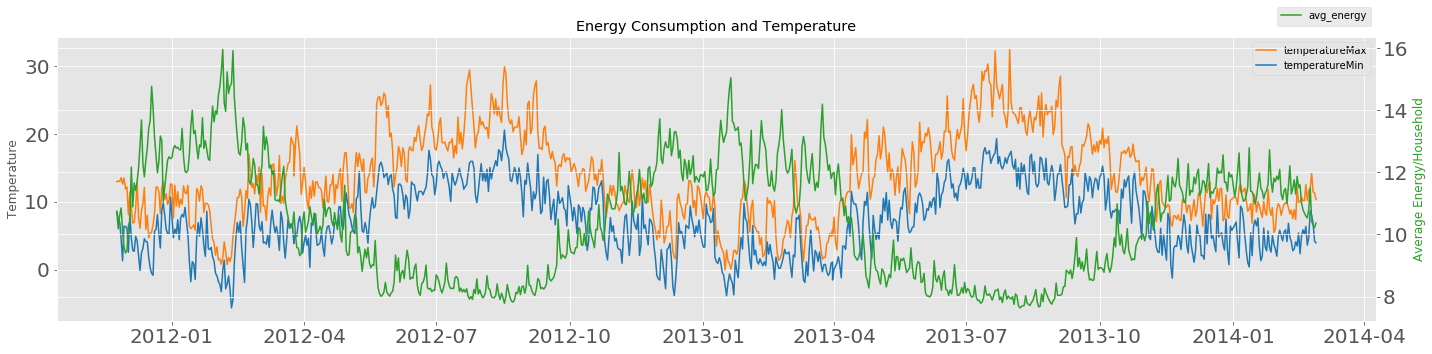

In [38]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color = 'tab:orange')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color = 'tab:blue')
ax1.set_ylabel('Temperature')
ax1.legend(("temperatureMax","temperatureMin"))
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green',label="avg_energy")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Temperature')
fig.tight_layout()
plt.show()


***2.  Humidity ***

>  Humidity and the average consumption of energy seems to have the same trend.


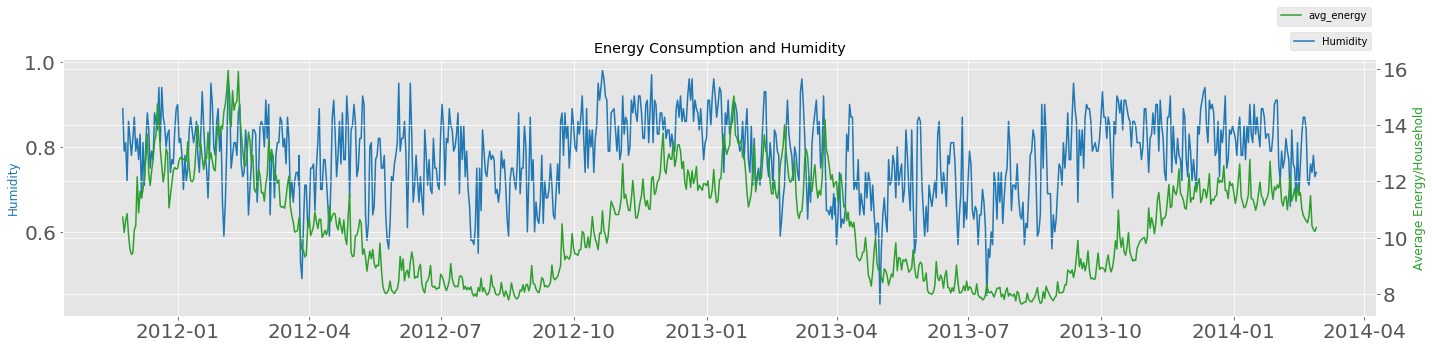

In [39]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:blue',label="Humidity")
ax1.set_ylabel('Humidity',color = 'tab:blue')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green',label="avg_energy")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.202))
plt.title('Energy Consumption and Humidity')
fig.tight_layout()
plt.show()

***3. Cloud Cover***
> The cloud cover value seems to be following the same pattern as the energy consumption.

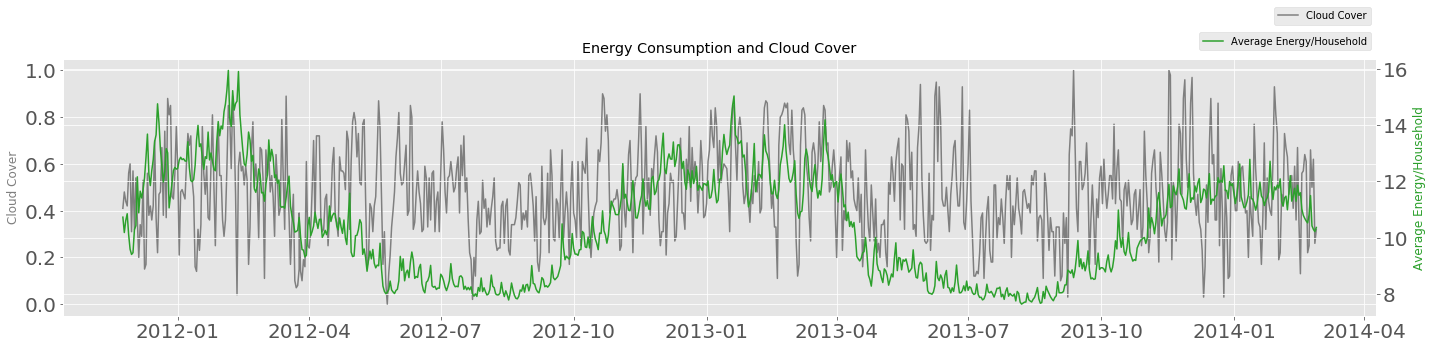

In [40]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:grey',label="Cloud Cover")
ax1.set_ylabel('Cloud Cover',color = 'tab:grey')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.202))
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green',label="Average Energy/Household")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Cloud Cover')
fig.tight_layout()
plt.show()

***4. Visibility***
> The visibility factor does not seem to affect energy consumption at all- since visibility is most likely an outdoors factor, it is unlikely that it's increase or decrease affects energy consumption within a household.

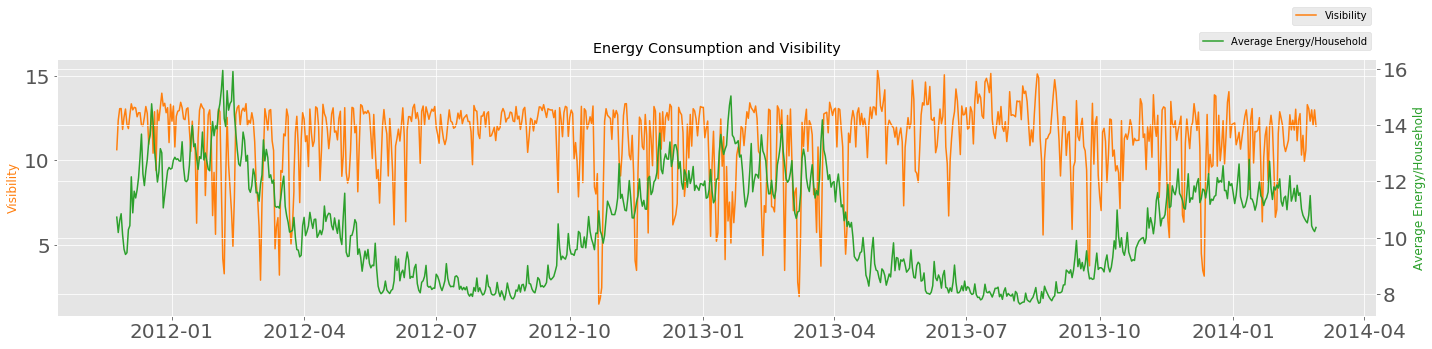

In [41]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:orange',label="Visibility")
ax1.set_ylabel('Visibility',color = 'tab:orange')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.202))
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green',label="Average Energy/Household")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Visibility')
fig.tight_layout()
plt.show()

***5.  Wind Speed***
>  Like visibility, wind speed seems to be an outdoors factor which does not affect in the energy consumption as such.

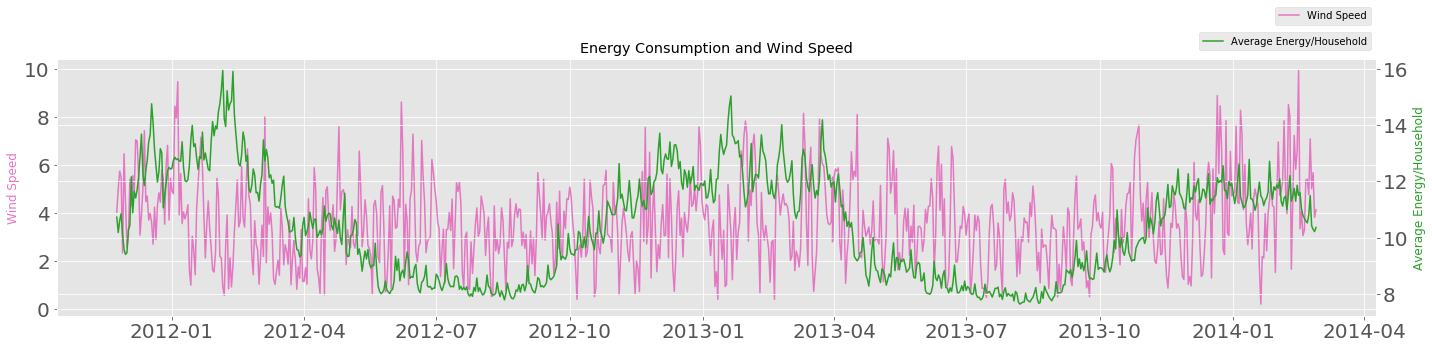

In [42]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:pink',label="Wind Speed")
ax1.set_ylabel('Wind Speed',color = 'tab:pink')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.202))
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green',label="Average Energy/Household")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

***6.  UV Index***
> The UV index has an inverse relationship with energy consumption- why?

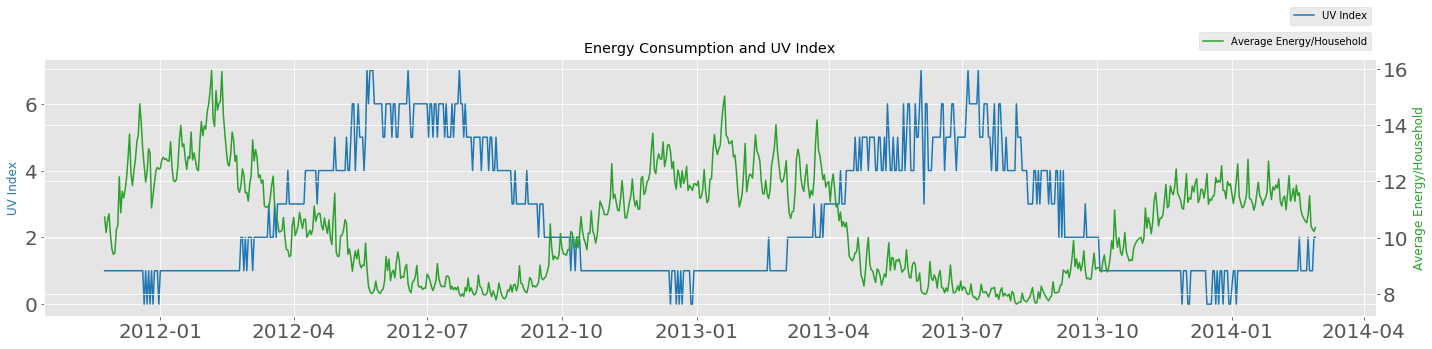

In [43]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:blue',label="UV Index")
ax1.set_ylabel('UV Index',color = 'tab:blue')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.202))
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green',label="Average Energy/Household")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and UV Index')
fig.tight_layout()
plt.show()

***7. dewPoint***
> Dew Point- is a function of humidity and temperature therefore it displays similar relation to energy consumption.

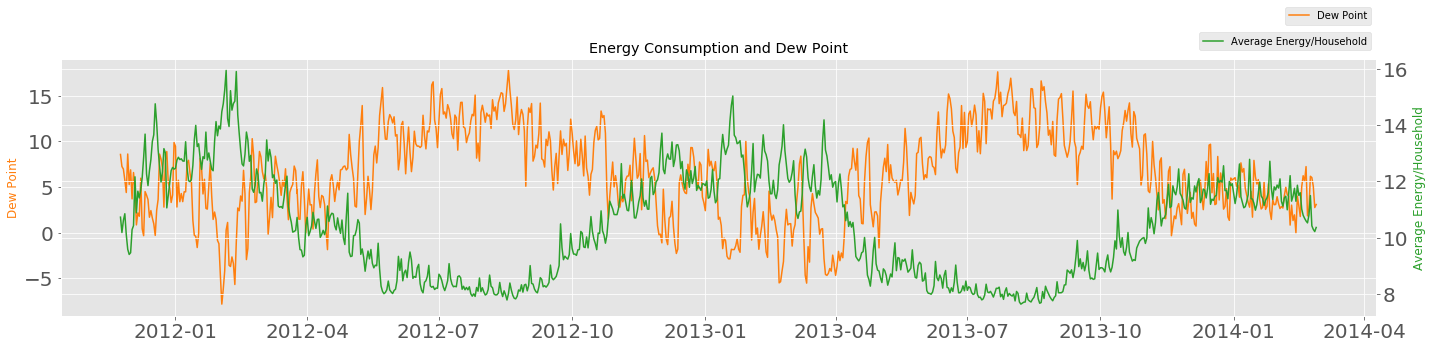

In [44]:
fig, ax1 = plt.subplots(figsize = (20,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:orange',label="Dew Point")
ax1.set_ylabel('Dew Point',color = 'tab:orange')
ax1.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.202))
ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green',label="Average Energy/Household")
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))
plt.title('Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

### UK Bank Holidays

In [45]:
holiday = pd.read_csv('/kaggle/input/smart-meters-in-london/uk_bank_holidays.csv')
holiday.rename(columns={"Bank holidays":"day"})
holiday.columns = ["day","Type"]

In [46]:
holiday['day'] = pd.to_datetime(holiday['day'],format='%Y-%m-%d').dt.date
holiday.head(4)

day                                          Type
0  2012-12-26                                    Boxing Day
1  2012-12-25                                 Christmas Day
2  2012-08-27                           Summer bank holiday
3  2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)

In [47]:
len(holiday)

25

In [48]:
holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
day     25 non-null object
Type    25 non-null object
dtypes: object(2)
memory usage: 528.0+ bytes


In [49]:
#weather_energy=pd.read_csv("D:/Project/smart-meters-in-london/outputfiles/weather_energy.csv")

**Creating a holiday indicator on weather data**

In [50]:
weather_energy_holiday = weather_energy.merge(holiday, left_on = 'day',right_on = 'day',how = 'left')

In [51]:
weather_energy_holiday.head(4)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-24  139.472000          13   10.728615           12.93   
1  2011-11-25  254.555000          25   10.182200           13.03   
2  2011-11-26  339.542000          32   10.610687           12.96   
3  2011-11-27  444.883001          41   10.850805           13.54   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  humidity  \
0          204      8.56        0.41       4.04   1027.22  ...      0.89   
1          243      7.24        0.48       5.02   1024.47  ...      0.79   
2          237      6.96        0.44       5.75   1025.80  ...      0.81   
3          256      5.76        0.42       5.48   1021.11  ...      0.72   

   apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
0                    7.30                   12.93      1.0            9.71   
1                    4.69                   13.03      1.0            7.01   
2                   11.59                   12.96      1.0           11.59   
3                    1.31                   13.54      1.0            1.31   

   temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  Type  
0            8.56            12.93                    7.01       0.97   NaN  
1            7.46            12.27                    4.84       0.01   NaN  
2            7.01            12.96                    4.69       0.05   NaN  
3            4.47            13.54                    2.94       0.08   NaN  

[4 rows x 22 columns]

In [52]:
weather_energy_holiday.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 826 entries, 0 to 825
Data columns (total 22 columns):
day                        826 non-null object
energy_sum                 826 non-null float64
HouseCount                 826 non-null int64
avg_energy                 826 non-null float64
temperatureMax             826 non-null float64
windBearing                826 non-null int64
dewPoint                   826 non-null float64
cloudCover                 826 non-null float64
windSpeed                  826 non-null float64
pressure                   826 non-null float64
apparentTemperatureHigh    826 non-null float64
visibility                 826 non-null float64
humidity                   826 non-null float64
apparentTemperatureLow     826 non-null float64
apparentTemperatureMax     826 non-null float64
uvIndex                    826 non-null float64
temperatureLow             826 non-null float64
temperatureMin             826 non-null float64
temperatureHigh            826 non-n

In [53]:
weather_energy_holiday["Type"].unique()

array([nan, 'New Year?s Day (substitute day)',
       'Spring bank holiday (substitute day)',
       'Queen?s Diamond Jubilee (extra bank holiday)', 'Good Friday',
       'Early May bank holiday', 'Summer bank holiday', 'Easter Monday',
       'Christmas Day', 'Boxing Day', 'New Year?s Day',
       'Spring bank holiday'], dtype=object)

In [54]:
weather_energy_holiday['Isholiday'] = np.where(weather_energy_holiday['Type'].isna(),0,1)

In [55]:
weather_energy_holiday.tail()

day    energy_sum  HouseCount  avg_energy  temperatureMax  \
821  2014-02-23  57054.144995        4963   11.495899           11.94   
822  2014-02-24  51887.913004        4979   10.421352           14.23   
823  2014-02-25  51100.037002        4964   10.294125           11.43   
824  2014-02-26  50499.851994        4943   10.216438           11.29   
825  2014-02-27  51584.610998        4978   10.362517           10.31   

     windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  \
821          200      6.17        0.66       7.10   1010.37  ...   
822          183      6.03        0.50       5.02   1005.19  ...   
823          202      5.06        0.62       5.69   1000.65  ...   
824          227      2.74        0.26       3.82   1012.73  ...   
825          224      3.08        0.32       4.14   1007.02  ...   

     apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
821                    5.52                   11.94      1.0            7.99   
822                    4.78                   14.23      1.0            8.25   
823                    1.67                   11.43      1.0            4.17   
824                    3.03                   11.29      2.0            6.01   
825                    0.82                   10.31      2.0            3.43   

     temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  Type  \
821            8.67            11.94                    5.53       0.78   NaN   
822            7.99            14.23                    5.52       0.82   NaN   
823            6.79            10.31                    3.89       0.86   NaN   
824            4.17            11.29                    1.67       0.90   NaN   
825            3.93            10.31                    1.41       0.93   NaN   

     Isholiday  
821          0  
822          0  
823          0  
824          0  
825          0  

[5 rows x 23 columns]

In [56]:
weather_energy_holiday['Isholiday'].unique()

array([0, 1])

In [57]:
weather_energy_holiday['DayOfWeek'] = pd.to_datetime(weather_energy_holiday['day']).dt.dayofweek  # monday = 0, sunday = 6
weather_energy_holiday['Isweekend'] = 0          # Initialize the column with default value of 0
weather_energy_holiday.loc[weather_energy_holiday['DayOfWeek'].isin([5, 6]), 'Isweekend'] = 1  # 5 and 6 correspond to Sat and Sun

In [58]:
weather_energy_holiday.head(7)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-24  139.472000          13   10.728615           12.93   
1  2011-11-25  254.555000          25   10.182200           13.03   
2  2011-11-26  339.542000          32   10.610687           12.96   
3  2011-11-27  444.883001          41   10.850805           13.54   
4  2011-11-28  414.328000          41   10.105561           12.58   
5  2011-11-29  527.315000          55    9.587545           13.47   
6  2011-11-30  592.384000          63    9.402921           11.87   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  uvIndex  \
0          204      8.56        0.41       4.04   1027.22  ...      1.0   
1          243      7.24        0.48       5.02   1024.47  ...      1.0   
2          237      6.96        0.44       5.75   1025.80  ...      1.0   
3          256      5.76        0.42       5.48   1021.11  ...      1.0   
4          190      4.39        0.56       2.34   1022.80  ...      1.0   
5          213      8.61        0.60       6.48   1009.70  ...      1.0   
6          205      5.26        0.31       4.43   1019.43  ...      1.0   

   temperatureLow  temperatureMin  temperatureHigh  apparentTemperatureMin  \
0            9.71            8.56            12.93                    7.01   
1            7.01            7.46            12.27                    4.84   
2           11.59            7.01            12.96                    4.69   
3            1.31            4.47            13.54                    2.94   
4           10.27            1.31            10.27                    1.31   
5            6.34            6.37            13.47                    3.39   
6            9.44            6.34            11.87                    3.34   

   moonPhase  Type  Isholiday  DayOfWeek  Isweekend  
0       0.97   NaN          0          3          0  
1       0.01   NaN          0          4          0  
2       0.05   NaN          0          5          1  
3       0.08   NaN          0          6          1  
4       0.12   NaN          0          0          0  
5       0.15   NaN          0          1          0  
6       0.19   NaN          0          2          0  

[7 rows x 25 columns]

In [59]:
weather_energy_holiday.drop(['Type','DayOfWeek'],axis=1,inplace=True)

In [60]:
weather_energy_holiday.head(4)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-24  139.472000          13   10.728615           12.93   
1  2011-11-25  254.555000          25   10.182200           13.03   
2  2011-11-26  339.542000          32   10.610687           12.96   
3  2011-11-27  444.883001          41   10.850805           13.54   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  \
0          204      8.56        0.41       4.04   1027.22  ...   
1          243      7.24        0.48       5.02   1024.47  ...   
2          237      6.96        0.44       5.75   1025.80  ...   
3          256      5.76        0.42       5.48   1021.11  ...   

   apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
0                    7.30                   12.93      1.0            9.71   
1                    4.69                   13.03      1.0            7.01   
2                   11.59                   12.96      1.0           11.59   
3                    1.31                   13.54      1.0            1.31   

   temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  \
0            8.56            12.93                    7.01       0.97   
1            7.46            12.27                    4.84       0.01   
2            7.01            12.96                    4.69       0.05   
3            4.47            13.54                    2.94       0.08   

   Isholiday  Isweekend  
0          0          0  
1          0          0  
2          0          1  
3          0          1  

[4 rows x 23 columns]

### we can make one column of holiday + weekend  = "holiday"

In [61]:
weather_energy_holiday["IsBankHoliday"] = weather_energy_holiday["Isholiday"]+weather_energy_holiday["Isweekend"]
weather_energy_holiday.loc[weather_energy_holiday["IsBankHoliday"]==2, ["IsBankHoliday"]]=1

In [62]:
weather_energy_holiday["IsBankHoliday"].unique()

array([0, 1])

In [63]:
weather_energy_holiday.columns

Index(['day', 'energy_sum', 'HouseCount', 'avg_energy', 'temperatureMax',
       'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase', 'Isholiday', 'Isweekend',
       'IsBankHoliday'],
      dtype='object')

In [64]:
weather_energy_holiday.drop(['Isholiday','Isweekend'],axis=1,inplace=True)

In [65]:
weather_energy_holiday.head(3)

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-24     139.472          13   10.728615           12.93   
1  2011-11-25     254.555          25   10.182200           13.03   
2  2011-11-26     339.542          32   10.610687           12.96   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  humidity  \
0          204      8.56        0.41       4.04   1027.22  ...      0.89   
1          243      7.24        0.48       5.02   1024.47  ...      0.79   
2          237      6.96        0.44       5.75   1025.80  ...      0.81   

   apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
0                    7.30                   12.93      1.0            9.71   
1                    4.69                   13.03      1.0            7.01   
2                   11.59                   12.96      1.0           11.59   

   temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  \
0            8.56            12.93                    7.01       0.97   
1            7.46            12.27                    4.84       0.01   
2            7.01            12.96                    4.69       0.05   

   IsBankHoliday  
0              0  
1              0  
2              1  

[3 rows x 22 columns]

In [66]:
weather_energy_holiday.shape

(826, 22)

In [67]:
weather_energy_holiday.to_csv("weather_energy_holiday.csv",index=False)

In [68]:
corr_mat = weather_energy_holiday.corr()

In [69]:
type(corr_mat)

pandas.core.frame.DataFrame

In [70]:
corr_mat.columns

Index(['energy_sum', 'HouseCount', 'avg_energy', 'temperatureMax',
       'windBearing', 'dewPoint', 'cloudCover', 'windSpeed', 'pressure',
       'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase', 'IsBankHoliday'],
      dtype='object')

In [71]:
corr_mat['avg_energy'] = corr_mat['avg_energy'].abs()

In [72]:
corr_mat['energy_sum'] = corr_mat['energy_sum'].abs()

In [73]:
corr_mat

energy_sum  HouseCount  avg_energy  temperatureMax  \
energy_sum                 1.000000    0.916450    0.057811       -0.190299   
HouseCount                 0.916450    1.000000    0.322341        0.165177   
avg_energy                 0.057811   -0.322341    1.000000       -0.872318   
temperatureMax             0.190299    0.165177    0.872318        1.000000   
windBearing                0.103700   -0.080464    0.022437        0.062939   
dewPoint                   0.130884    0.183306    0.776912        0.865084   
cloudCover                 0.127639    0.022099    0.247190       -0.333138   
windSpeed                  0.040927   -0.025537    0.146507       -0.155408   
pressure                   0.273140   -0.222706    0.021184        0.118355   
apparentTemperatureHigh    0.211092    0.143932    0.871459        0.986223   
visibility                 0.118410   -0.007930    0.252445        0.258472   
humidity                   0.139158   -0.019389    0.376810       -0.403972   
apparentTemperatureLow     0.141546    0.192381    0.816044        0.894671   
apparentTemperatureMax     0.206728    0.147481    0.870219        0.989679   
uvIndex                    0.197727    0.093124    0.749449        0.696073   
temperatureLow             0.139640    0.184228    0.793587        0.882328   
temperatureMin             0.146433    0.192080    0.832469        0.895445   
temperatureHigh            0.194298    0.161869    0.872700        0.997842   
apparentTemperatureMin     0.142979    0.204805    0.855221        0.910729   
moonPhase                  0.013819    0.029298    0.010884        0.006599   
IsBankHoliday              0.048473    0.004771    0.118365       -0.024621   

                         windBearing  dewPoint  cloudCover  windSpeed  \
energy_sum                 -0.103700 -0.130884    0.127639   0.040927   
HouseCount                 -0.080464  0.183306    0.022099  -0.025537   
avg_energy                 -0.022437 -0.776912    0.247190   0.146507   
temperatureMax              0.062939  0.865084   -0.333138  -0.155408   
windBearing                 1.000000  0.094331   -0.080068   0.072721   
dewPoint                    0.094331  1.000000   -0.024435  -0.093055   
cloudCover                 -0.080068 -0.024435    1.000000   0.170798   
windSpeed                   0.072721 -0.093055    0.170798   1.000000   
pressure                   -0.015158 -0.029264   -0.098830  -0.345353   
apparentTemperatureHigh     0.071946  0.870418   -0.309422  -0.188251   
visibility                  0.260134  0.042426   -0.331648   0.279922   
humidity                    0.024049  0.056451    0.481572  -0.039944   
apparentTemperatureLow      0.050170  0.896164   -0.137932  -0.146827   
apparentTemperatureMax      0.073837  0.874345   -0.305313  -0.175643   
uvIndex                    -0.092719  0.486490   -0.248740  -0.154676   
temperatureLow              0.052090  0.893920   -0.105830  -0.072760   
temperatureMin              0.066493  0.939026   -0.060378  -0.023334   
temperatureHigh             0.058350  0.861931   -0.335040  -0.163762   
apparentTemperatureMin      0.054850  0.940548   -0.101702  -0.133928   
moonPhase                   0.038710 -0.006791   -0.063175  -0.020094   
IsBankHoliday               0.003161 -0.037381   -0.041145   0.007805   

                         pressure  apparentTemperatureHigh  ...  humidity  \
energy_sum              -0.273140                -0.211092  ...  0.139158   
HouseCount              -0.222706                 0.143932  ... -0.019389   
avg_energy              -0.021184                -0.871459  ...  0.376810   
temperatureMax           0.118355                 0.986223  ... -0.403972   
windBearing             -0.015158                 0.071946  ...  0.024049   
dewPoint                -0.029264                 0.870418  ...  0.056451   
cloudCover              -0.098830                -0.309422  ...  0.481572   
windSpeed               -0.345353                -0.188251  ...

In [74]:
corr_mat.sort_values(by=['avg_energy','energy_sum'], ascending=False, inplace=True)

In [75]:
corr_mat["avg_energy"].head(15)

avg_energy                 1.000000
temperatureHigh            0.872700
temperatureMax             0.872318
apparentTemperatureHigh    0.871459
apparentTemperatureMax     0.870219
apparentTemperatureMin     0.855221
temperatureMin             0.832469
apparentTemperatureLow     0.816044
temperatureLow             0.793587
dewPoint                   0.776912
uvIndex                    0.749449
humidity                   0.376810
HouseCount                 0.322341
visibility                 0.252445
cloudCover                 0.247190
Name: avg_energy, dtype: float64

# **Arima**

### Arima Forecasting in python
https://towardsdatascience.com/arima-forecasting-in-python-90d36c2246d3

1. **import required packages**

In [76]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 12
plt.style.use("ggplot")

required columns

In [77]:
weather_energy_holiday = pd.read_csv("/kaggle/working/weather_energy_holiday.csv")
weather_energy_holiday.head()

day  energy_sum  HouseCount  avg_energy  temperatureMax  \
0  2011-11-24  139.472000          13   10.728615           12.93   
1  2011-11-25  254.555000          25   10.182200           13.03   
2  2011-11-26  339.542000          32   10.610687           12.96   
3  2011-11-27  444.883001          41   10.850805           13.54   
4  2011-11-28  414.328000          41   10.105561           12.58   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  humidity  \
0          204      8.56        0.41       4.04   1027.22  ...      0.89   
1          243      7.24        0.48       5.02   1024.47  ...      0.79   
2          237      6.96        0.44       5.75   1025.80  ...      0.81   
3          256      5.76        0.42       5.48   1021.11  ...      0.72   
4          190      4.39        0.56       2.34   1022.80  ...      0.86   

   apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
0                    7.30                   12.93      1.0            9.71   
1                    4.69                   13.03      1.0            7.01   
2                   11.59                   12.96      1.0           11.59   
3                    1.31                   13.54      1.0            1.31   
4                   10.27                   12.58      1.0           10.27   

   temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  \
0            8.56            12.93                    7.01       0.97   
1            7.46            12.27                    4.84       0.01   
2            7.01            12.96                    4.69       0.05   
3            4.47            13.54                    2.94       0.08   
4            1.31            10.27                    1.31       0.12   

   IsBankHoliday  
0              0  
1              0  
2              1  
3              1  
4              0  

[5 rows x 22 columns]

In [78]:
arima_df = weather_energy_holiday[["day", "avg_energy"]]
arima_df["day"] = pd.to_datetime(arima_df["day"])
arima_df.head()

day  avg_energy
0 2011-11-24   10.728615
1 2011-11-25   10.182200
2 2011-11-26   10.610687
3 2011-11-27   10.850805
4 2011-11-28   10.105561

In [79]:
arima_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 826 entries, 0 to 825
Data columns (total 2 columns):
day           826 non-null datetime64[ns]
avg_energy    826 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 13.0 KB


# **CONVERT IT TO TIME SERIES DATASET**

In [80]:
arima_df.set_index("day", inplace=True)
arima_df.head()

avg_energy
day                   
2011-11-24   10.728615
2011-11-25   10.182200
2011-11-26   10.610687
2011-11-27   10.850805
2011-11-28   10.105561

In [81]:
ts = arima_df["avg_energy"]
ts.head()

day
2011-11-24    10.728615
2011-11-25    10.182200
2011-11-26    10.610687
2011-11-27    10.850805
2011-11-28    10.105561
Name: avg_energy, dtype: float64

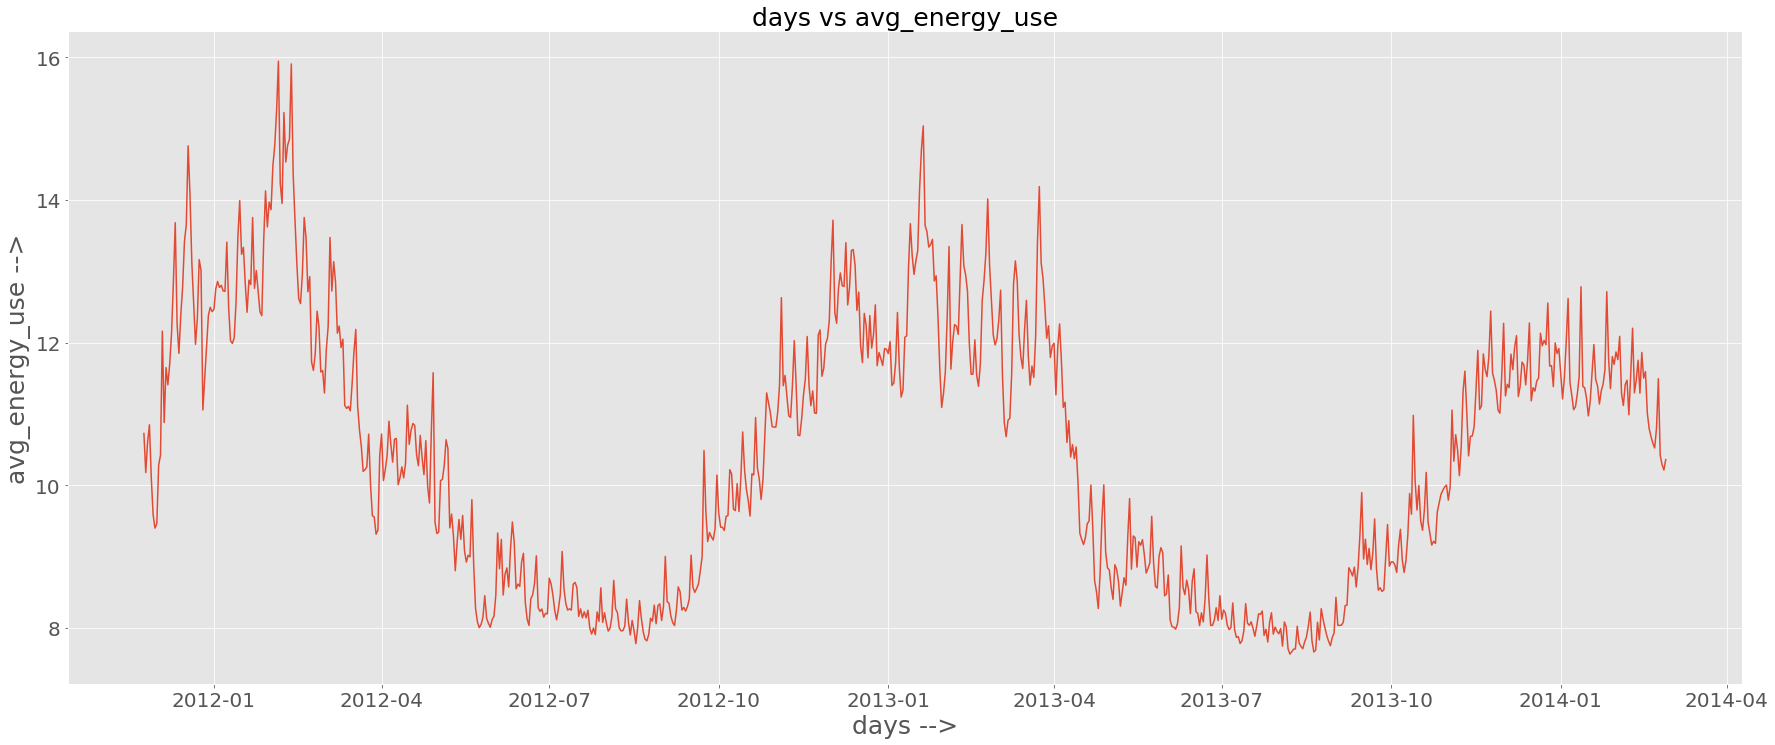

In [82]:
plt.plot(ts)
plt.xlabel("days -->", fontsize=25)
plt.ylabel("avg_energy_use -->", fontsize=25)
plt.title("days vs avg_energy_use", fontsize=25)
#plt.tick_params(labelsize=24)
plt.show()

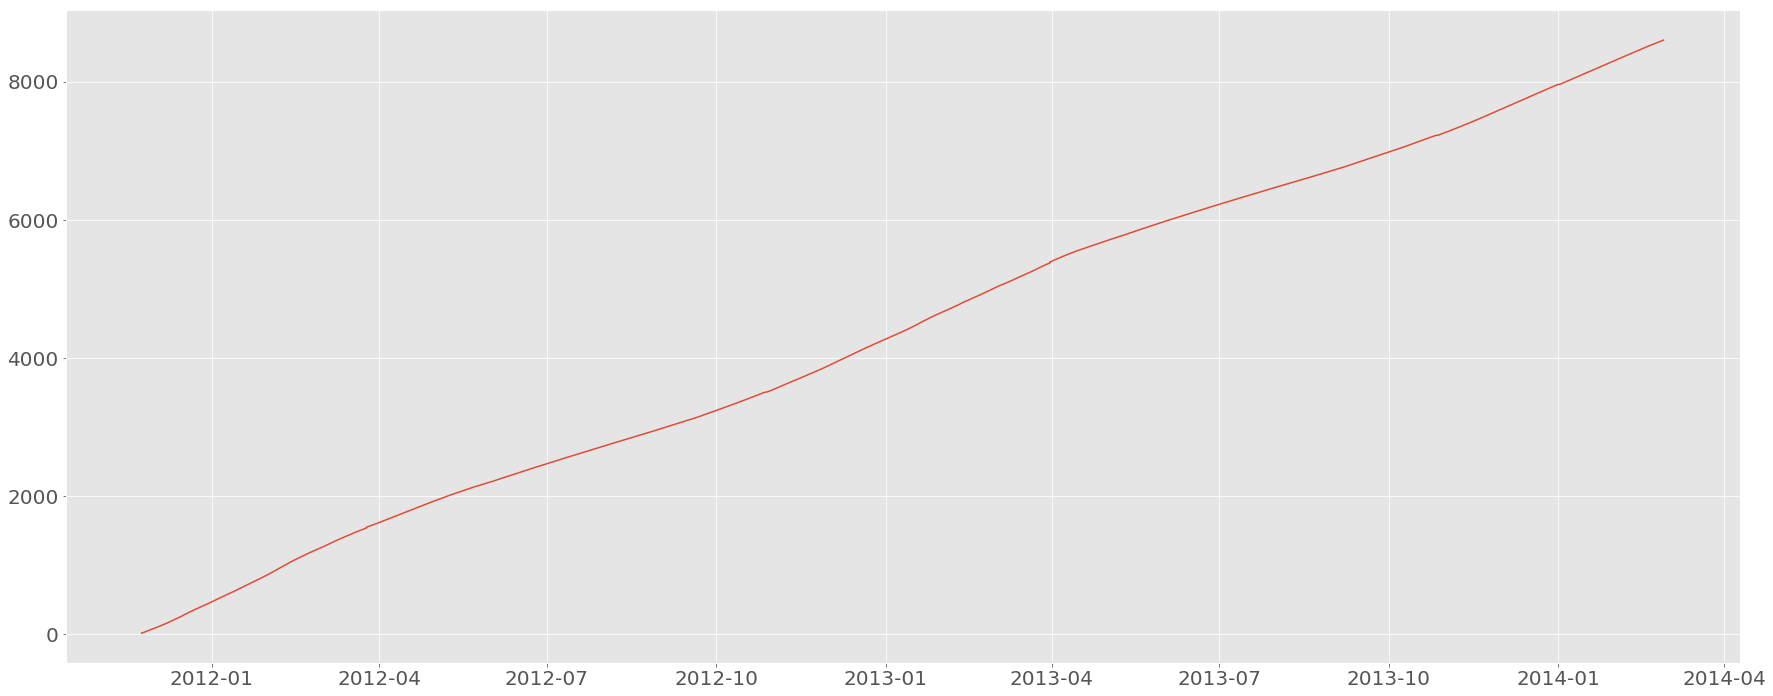

In [83]:
plt.plot(np.cumsum(ts))

# **RESAMPLE DATA**

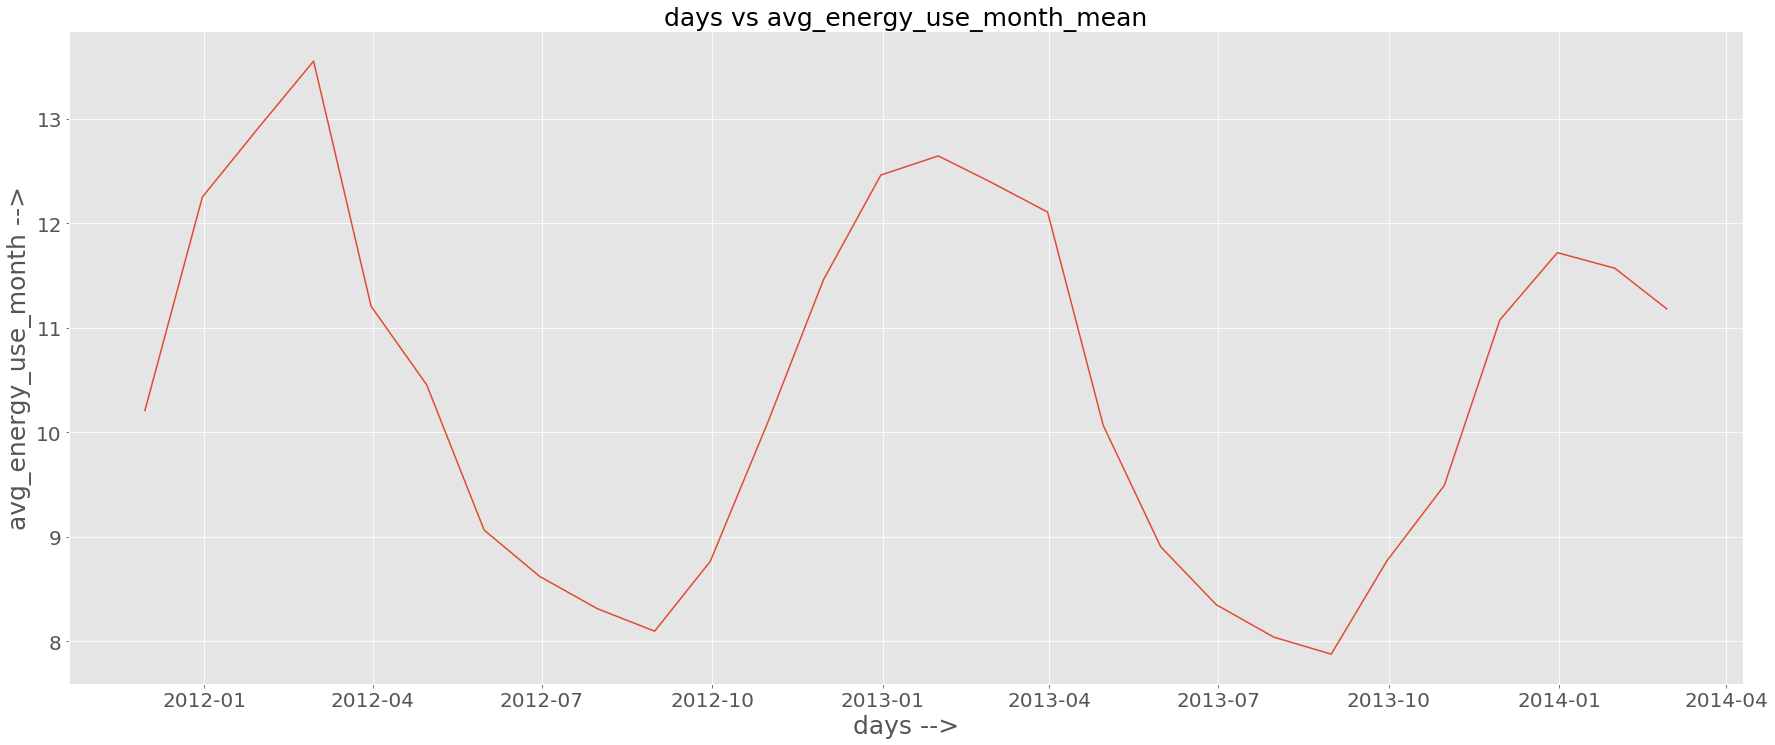

In [84]:
ts_month_mean = ts.resample("M").mean()
plt.plot(ts_month_mean)
plt.xlabel("days -->", fontsize=25)
plt.ylabel("avg_energy_use_month -->", fontsize=25)
plt.title("days vs avg_energy_use_month_mean", fontsize=25)
#plt.tick_params(labelsize=24)
plt.show()

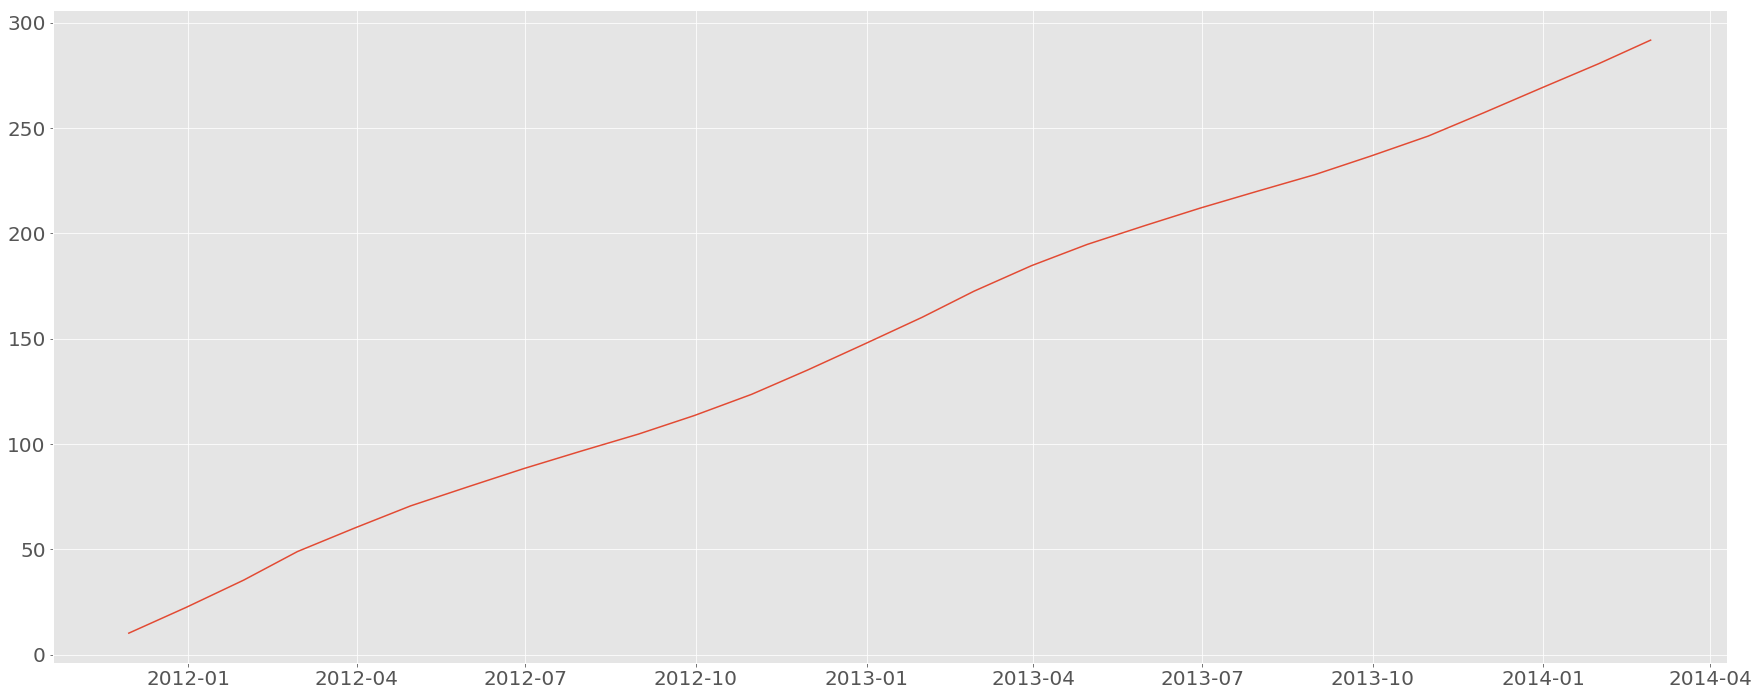

In [85]:
plt.plot(np.cumsum(ts_month_mean))

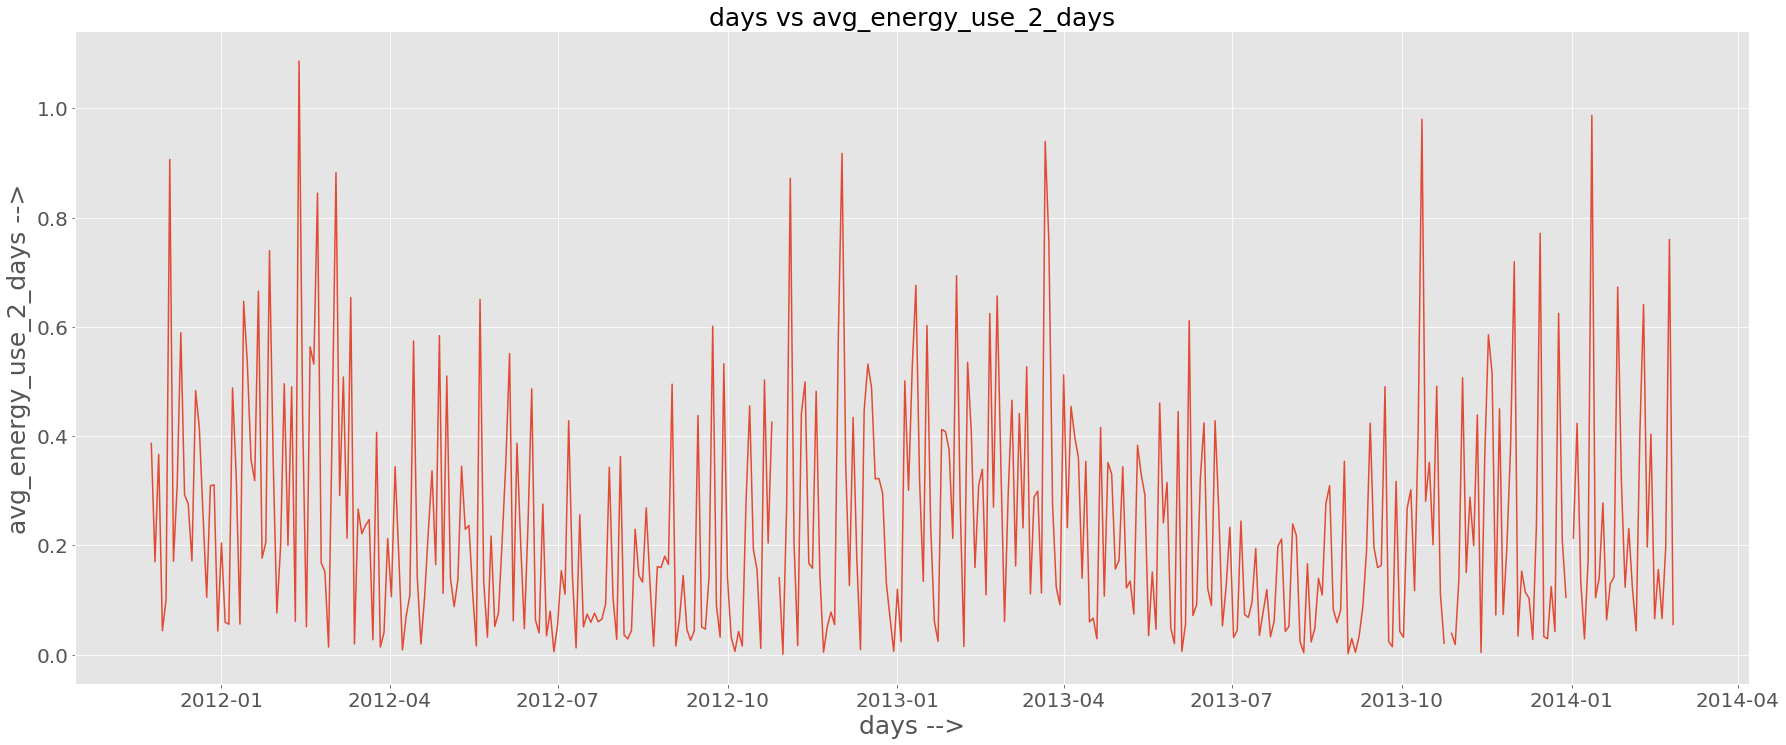

In [86]:
ts_std = ts.resample("2d").std()
plt.plot(ts_std)
plt.xlabel("days -->", fontsize=25)
plt.ylabel("avg_energy_use_2_days -->", fontsize=25)
plt.title("days vs avg_energy_use_2_days", fontsize=25)
#plt.tick_params(labelsize=24)
plt.show()

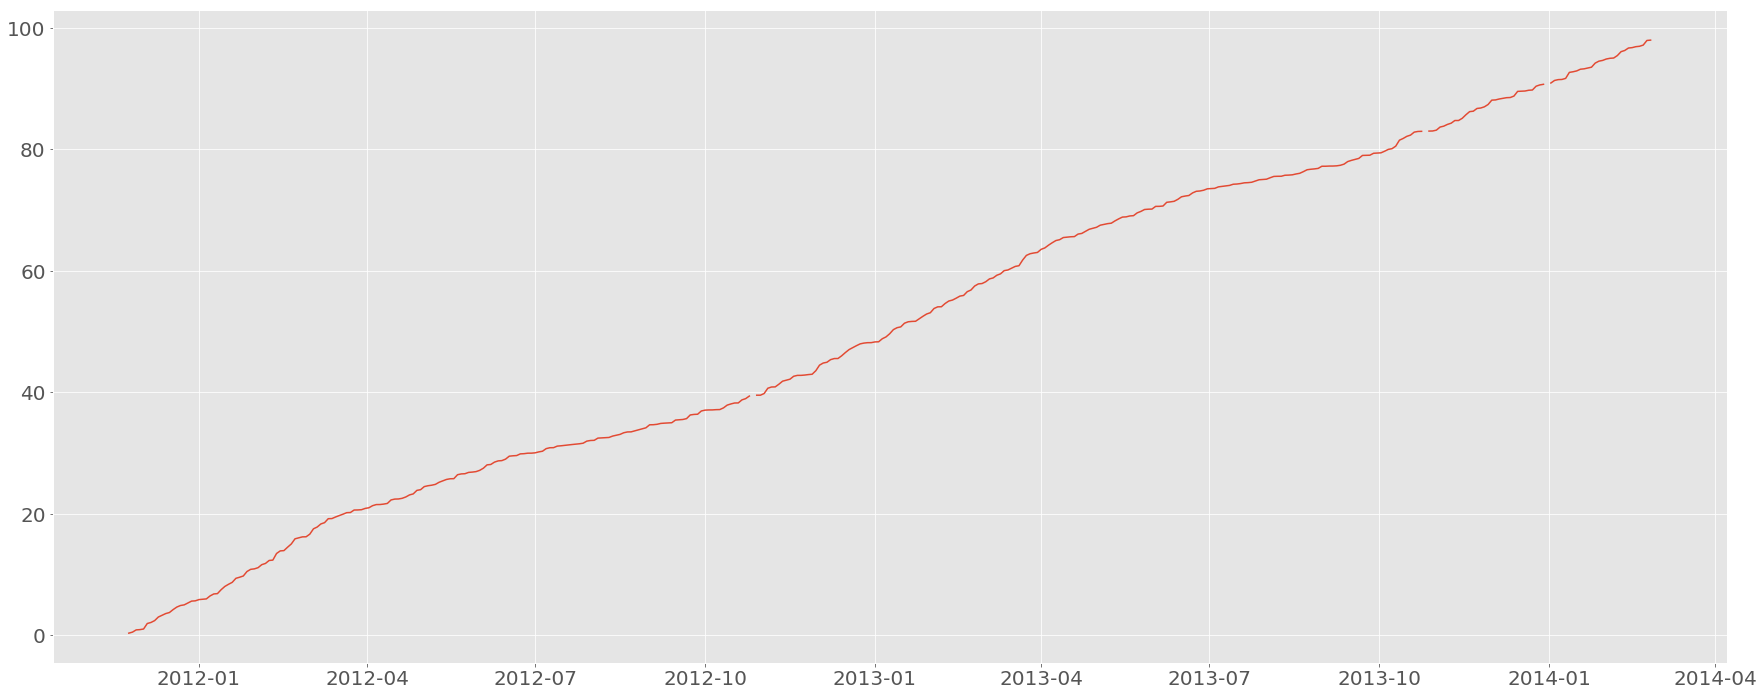

In [87]:
plt.plot(np.cumsum(ts_std))

# **Stationary Check Using Dicky Fuller Test**

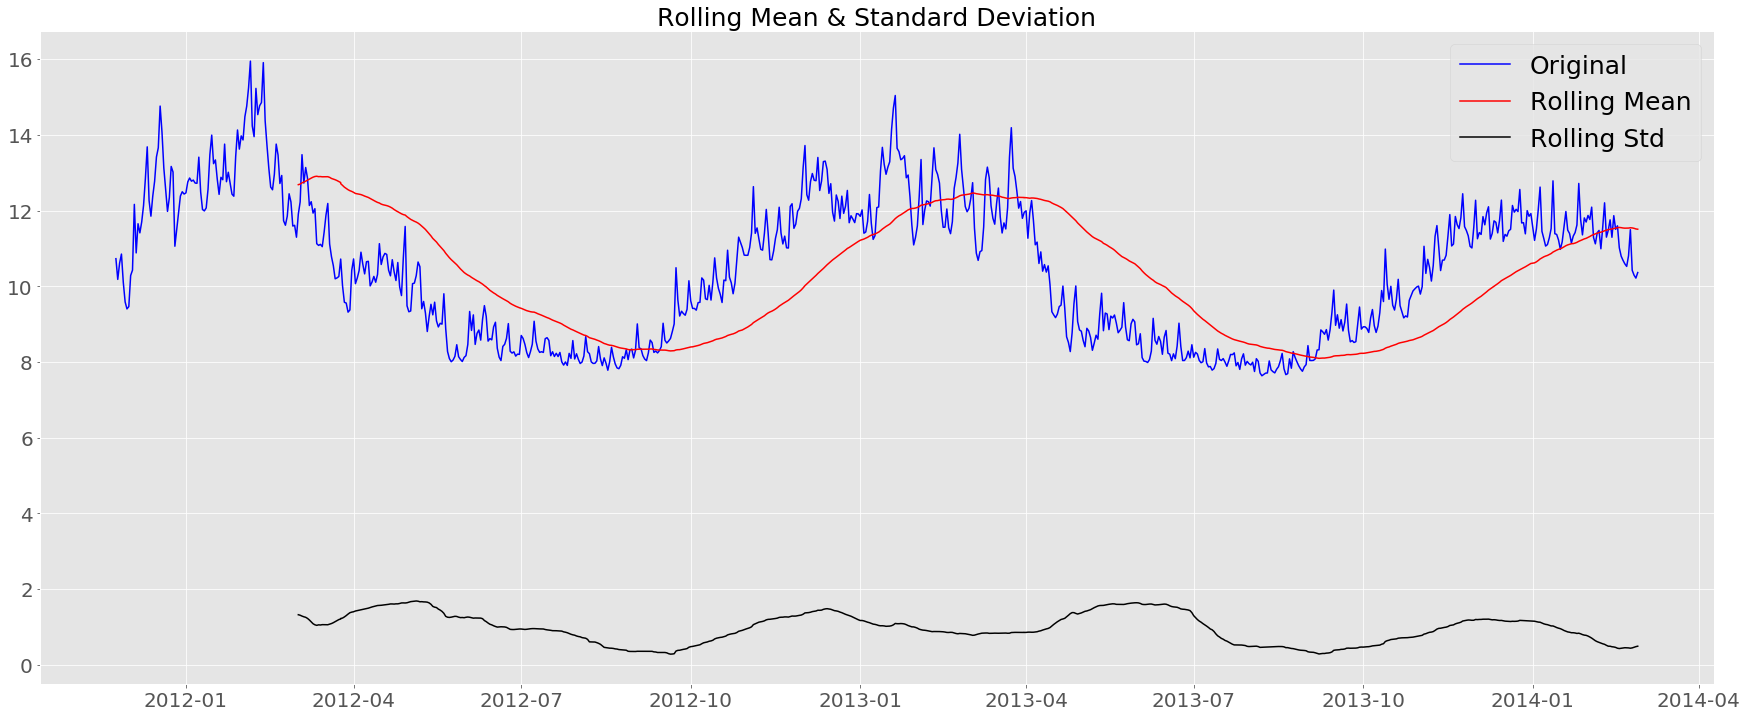

Results of Dickey-Fuller Test:
Test Statistic                  -2.043470
p-value                          0.267844
#Lags Used                      21.000000
Number of Observations Used    804.000000
Critical Value (1%)             -3.438510
Critical Value (5%)             -2.865142
Critical Value (10%)            -2.568688
dtype: float64


In [88]:
def test_stationarity(timeseries):
    #Determining rolling statistics
    rolmean = timeseries.rolling(window=100,center=False).mean() 
    rolstd = timeseries.rolling(window=100,center=False).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    
    plt.legend(loc='best', fontsize=25)
    plt.title('Rolling Mean & Standard Deviation', fontsize=25)
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)

## H0 -> Non-stationary
## H1 -> stationary
### p-value = 0.267844        
### :: i.e. greater than 0.05 
### H0 -> accepted  
### H1 -> rejected

Text(0.5, 1.0, 'ts_log_diff graph')

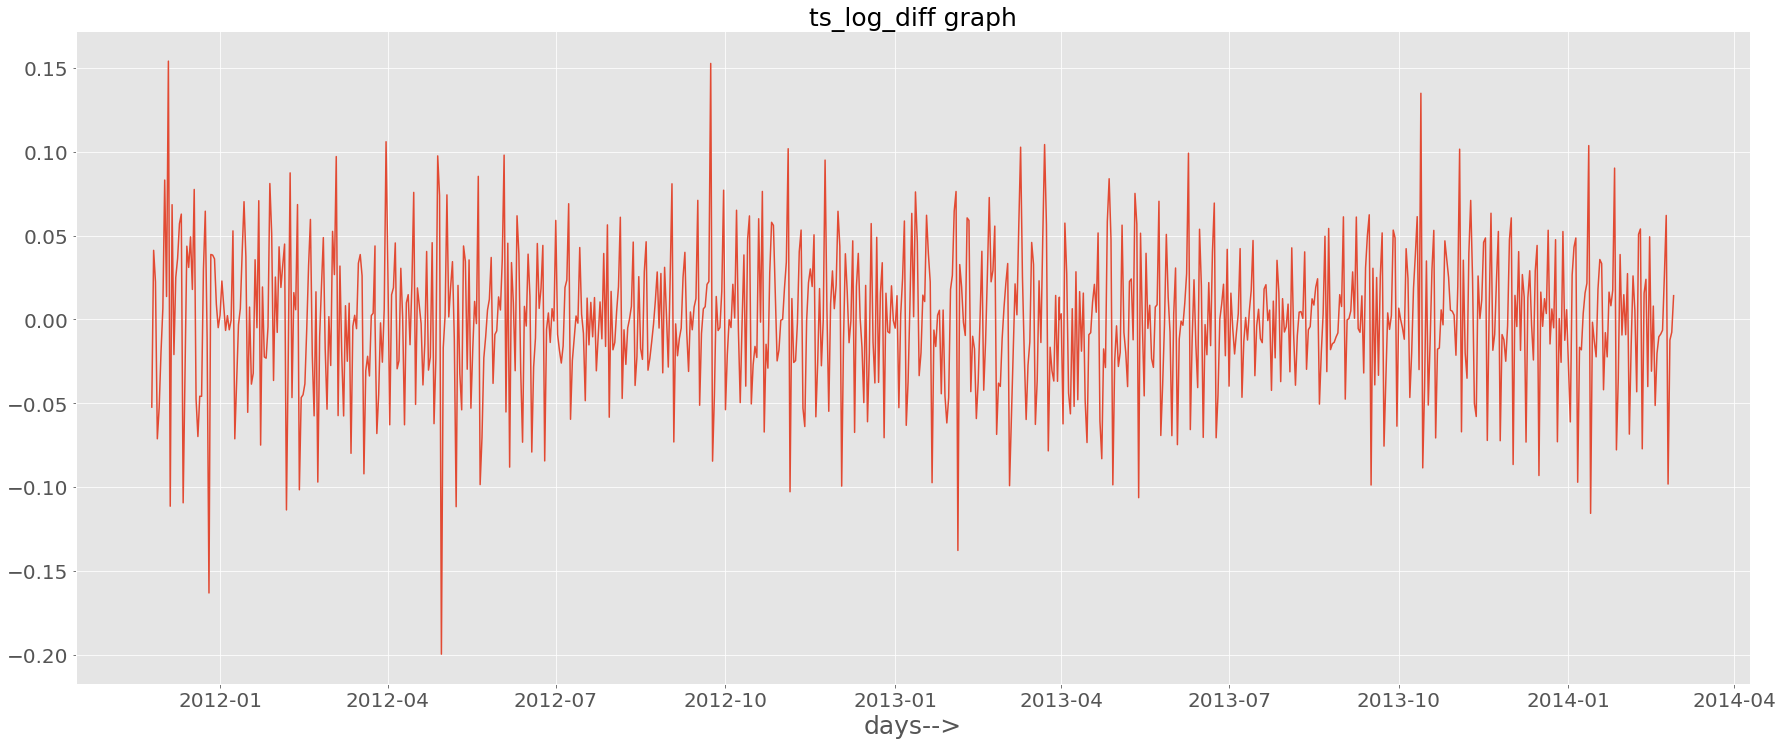

In [89]:
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.xlabel("days-->", fontsize=25)
plt.title("ts_log_diff graph", fontsize=25)

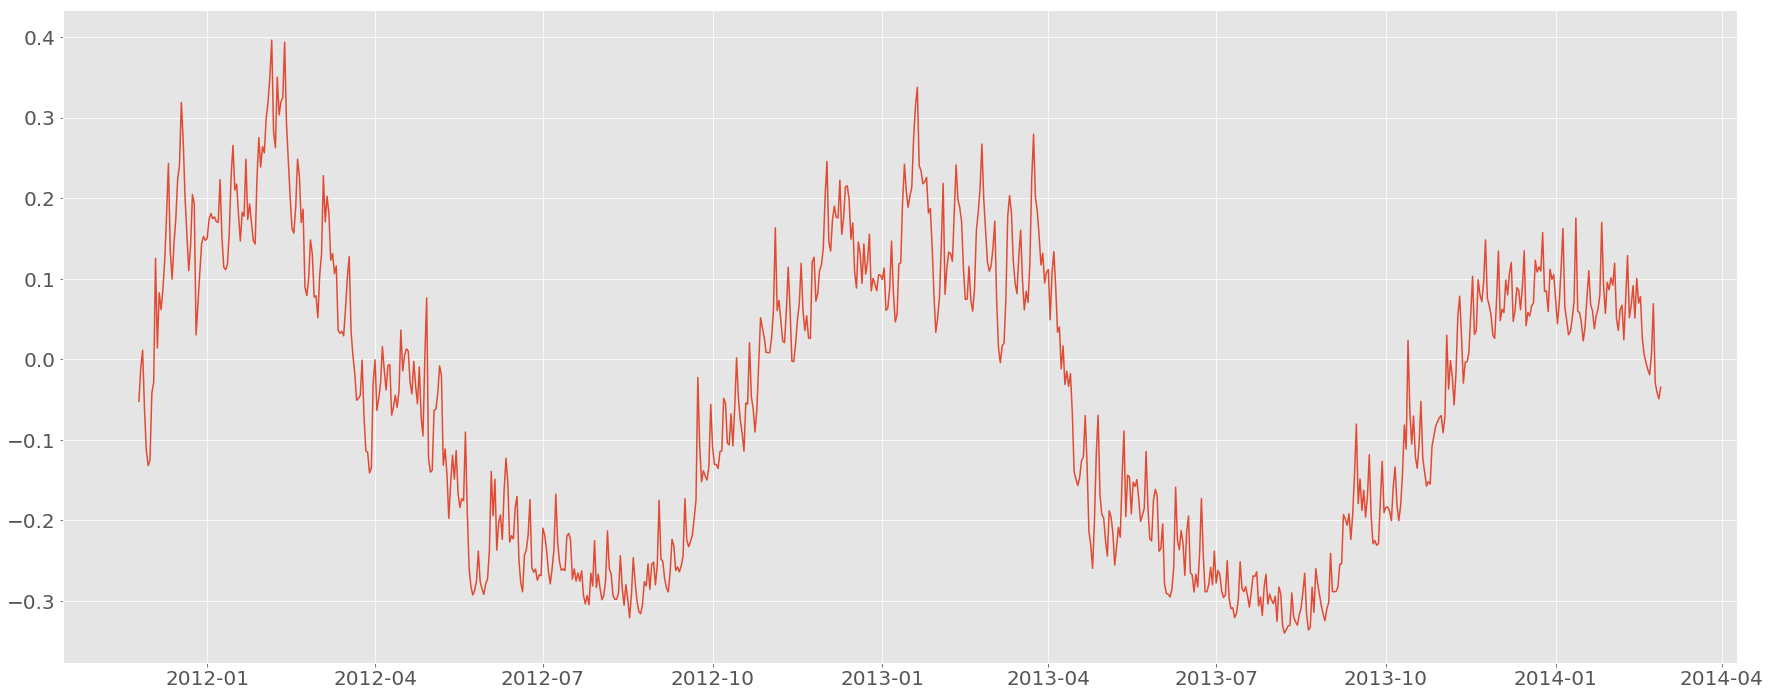

In [90]:
plt.plot(np.cumsum(ts_log_diff))

# Dickey Fuller Test On Transformed Data

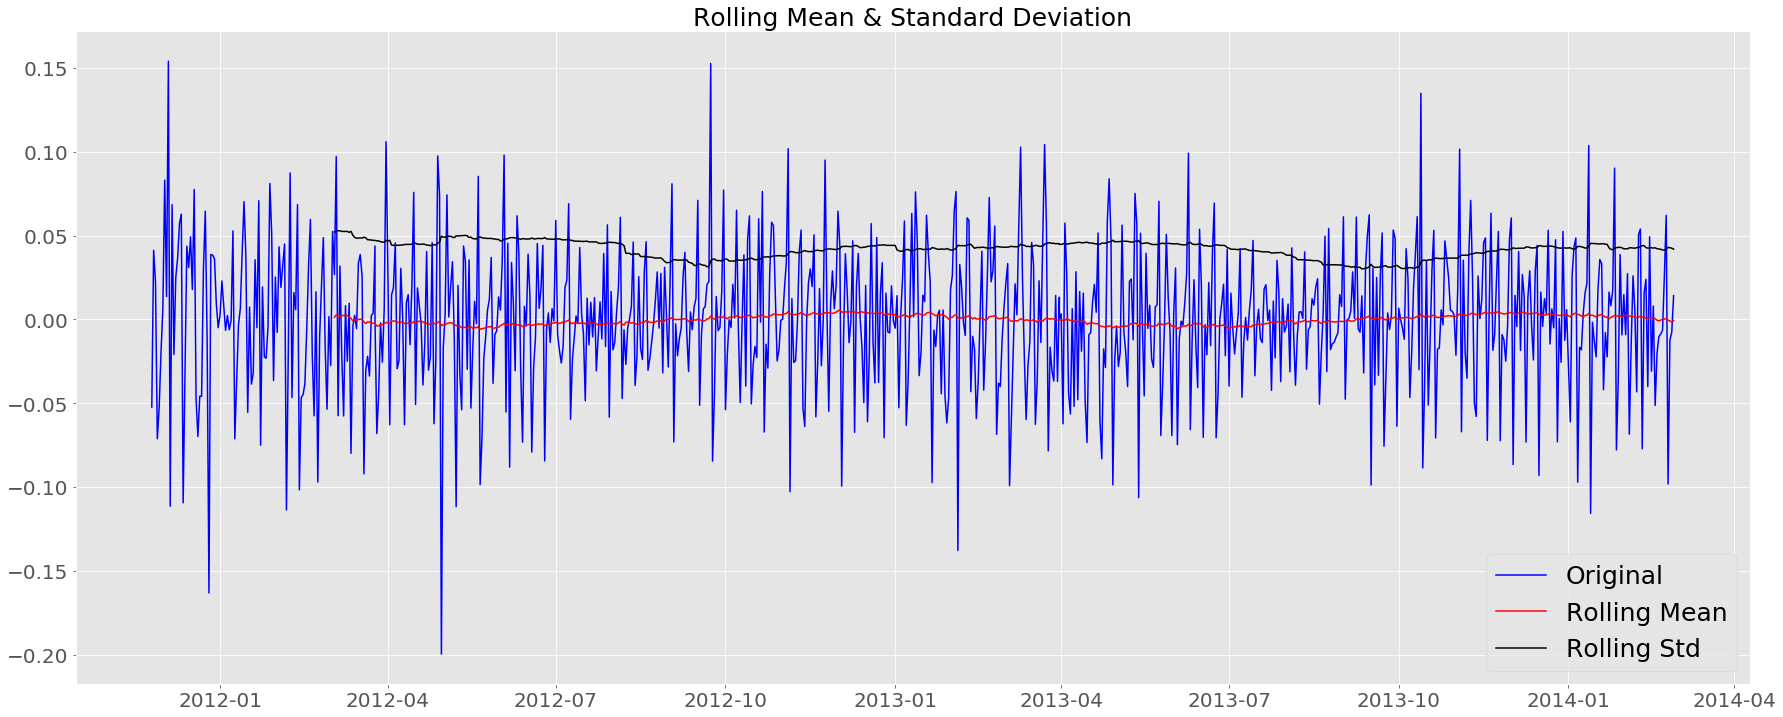

Results of Dickey-Fuller Test:
Test Statistic                -6.418407e+00
p-value                        1.816927e-08
#Lags Used                     2.000000e+01
Number of Observations Used    8.040000e+02
Critical Value (1%)           -3.438510e+00
Critical Value (5%)           -2.865142e+00
Critical Value (10%)          -2.568688e+00
dtype: float64


In [91]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

## H0 --> Non-stationary
## H1 --> stationary
### p-value = 1.816927e-08  
### :: i.e. less than 0.05 
### H0 -> rejected  
### H1 -> accepted

# Identify The ACF and PACF For The Data

Order p is the lag value after which PACF plot crosses the upper confidence interval for the first time. These p lags will act as our features while forecasting the AR time series.


Order q of the MA process is obtained from the ACF plot, this is the lag after which ACF crosses the upper confidence interval for the first time.

In [92]:
#ACF and PACF
lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

In [93]:
lag_acf

array([ 1.        , -0.10465498, -0.15632649, -0.09564757, -0.07511064,
       -0.14130468,  0.01356445,  0.38085202, -0.00536877, -0.14903659,
       -0.06226248])

In [94]:
lag_pacf

array([ 1.        , -0.1046683 , -0.16902603, -0.13771159, -0.14134129,
       -0.23274779, -0.12173416,  0.29921425,  0.05452606, -0.07432494,
       -0.04012115])

Text(0.5, 1.0, 'Autocorrelation Function')

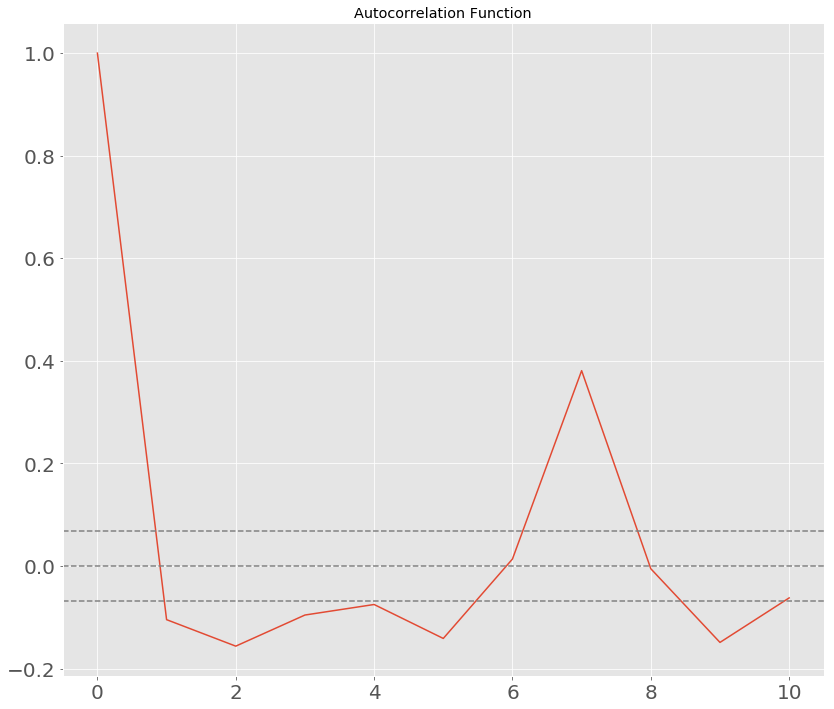

In [95]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

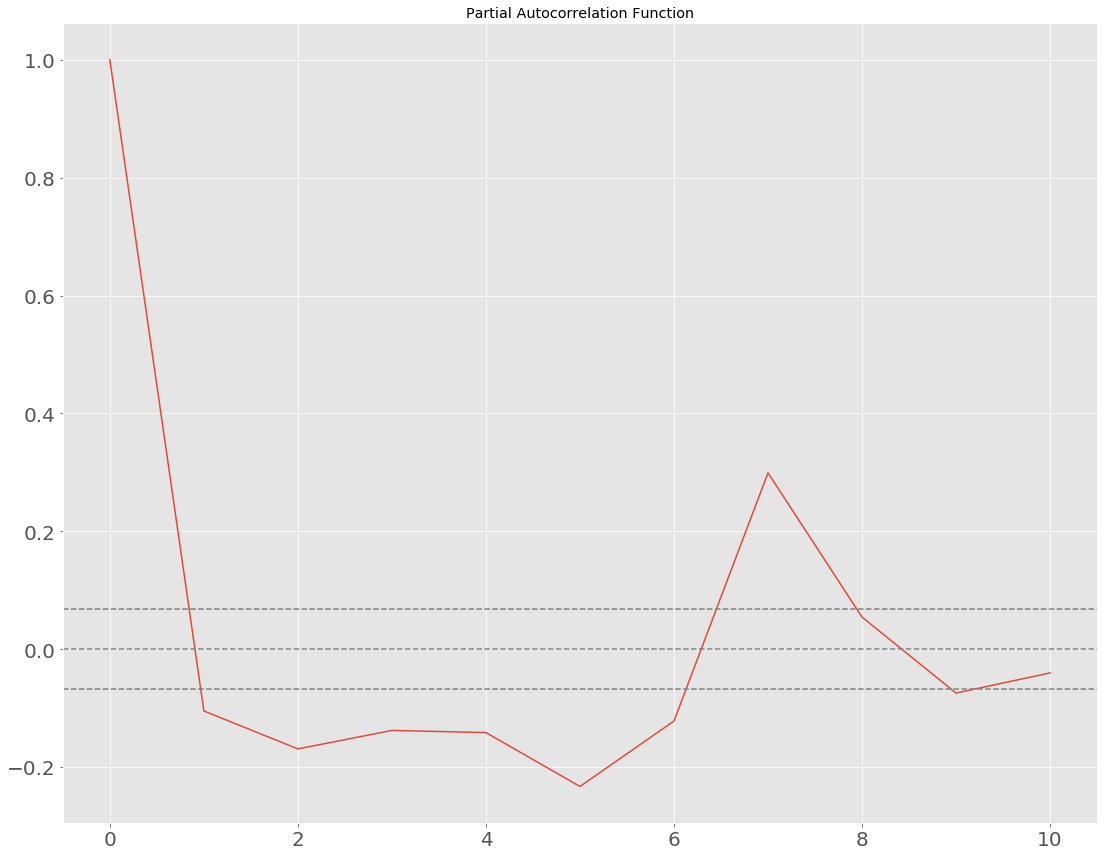

In [96]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# ARIMA Model Implementation

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 1.3052')

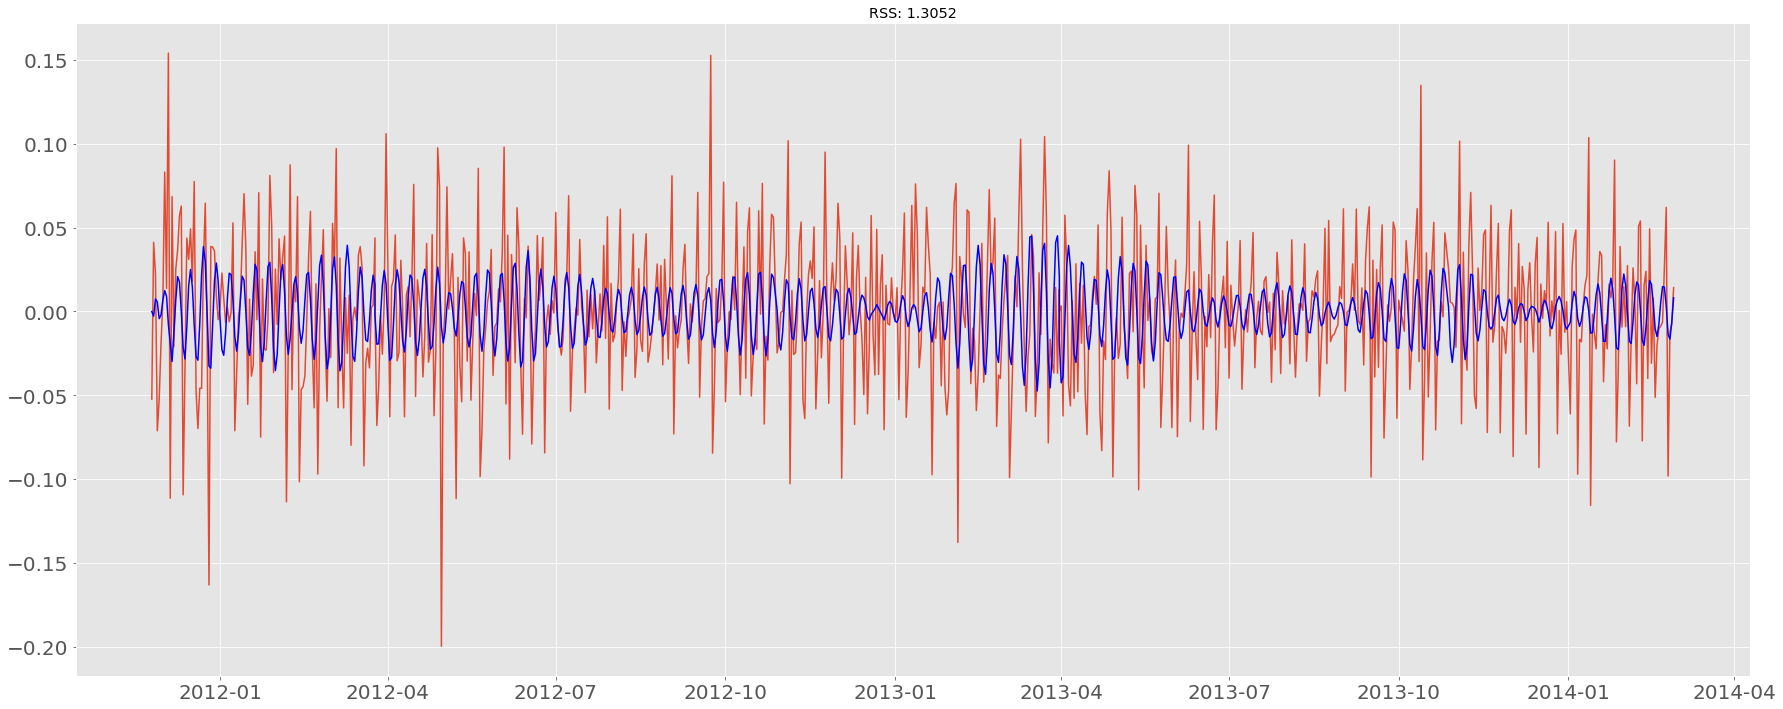

In [97]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='blue')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [98]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:           D.avg_energy   No. Observations:                  825
Model:                 ARIMA(2, 1, 2)   Log Likelihood                1490.807
Method:                       css-mle   S.D. of innovations              0.040
Date:                Wed, 12 Feb 2020   AIC                          -2969.615
Time:                        03:40:47   BIC                          -2941.322
Sample:                             1   HQIC                         -2958.762
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -6.449e-05      0.001     -0.051      0.959      -0.003       0.002
ar.L1.D.avg_energy     1.2475      0.008    160.498      0.000       1.232       1.263
ar.L2.D.avg_energy  

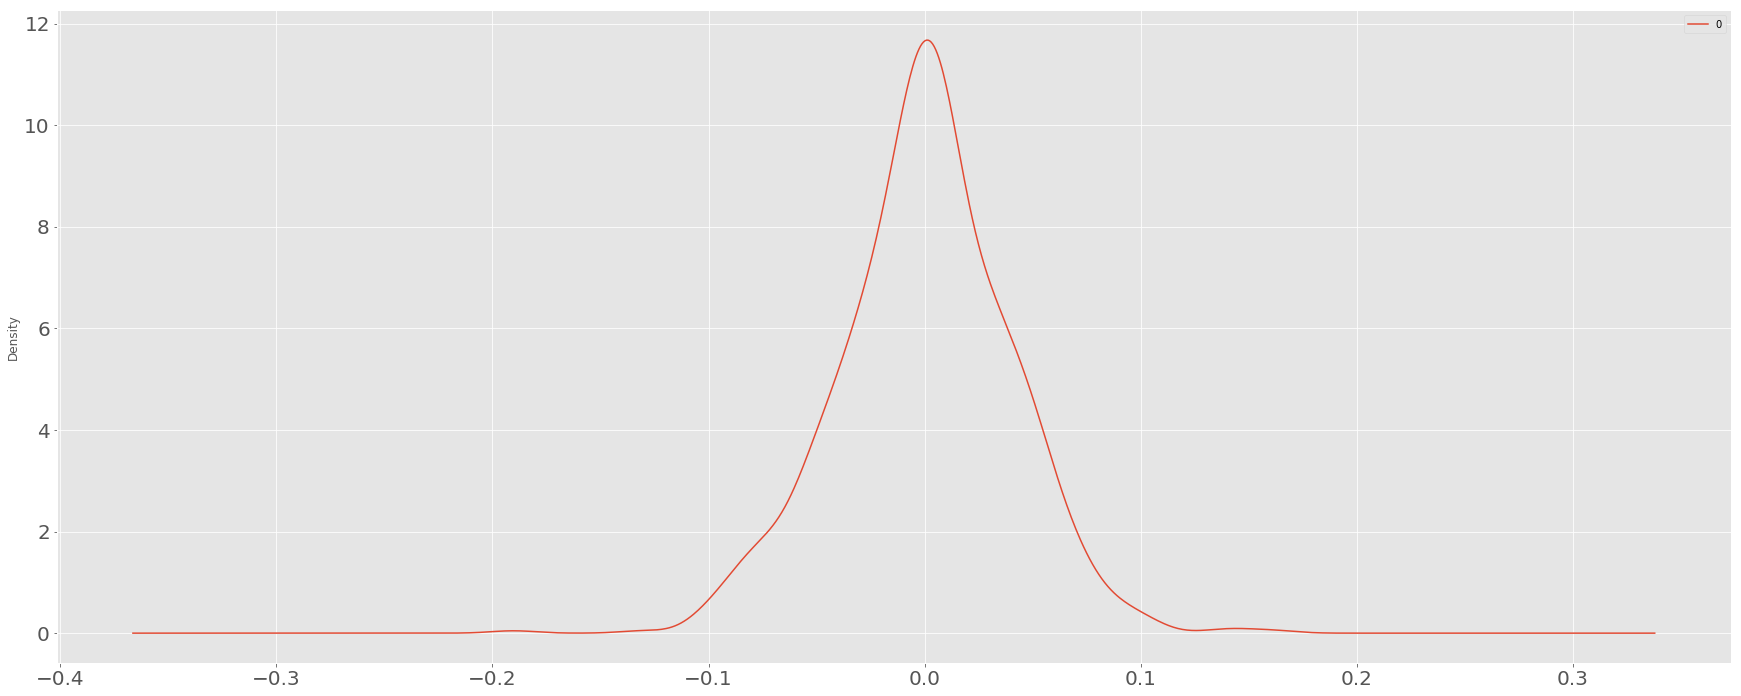

In [99]:
#print(results_ARIMA.summary())
## plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
#print(residuals.describe())

# Future Prediction Using ARIMA Model

In [100]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

day
2011-11-25   -0.000064
2011-11-26   -0.002750
2011-11-27    0.007464
2011-11-28    0.005596
2011-11-29   -0.004289
dtype: float64


In [101]:
ts_log

day
2011-11-24    2.372915
2011-11-25    2.320641
2011-11-26    2.361862
2011-11-27    2.384239
2011-11-28    2.313086
                ...   
2014-02-23    2.441990
2014-02-24    2.343857
2014-02-25    2.331573
2014-02-26    2.323998
2014-02-27    2.338195
Name: avg_energy, Length: 826, dtype: float64

Text(0.5, 1.0, 'RMSE: 8.1904')

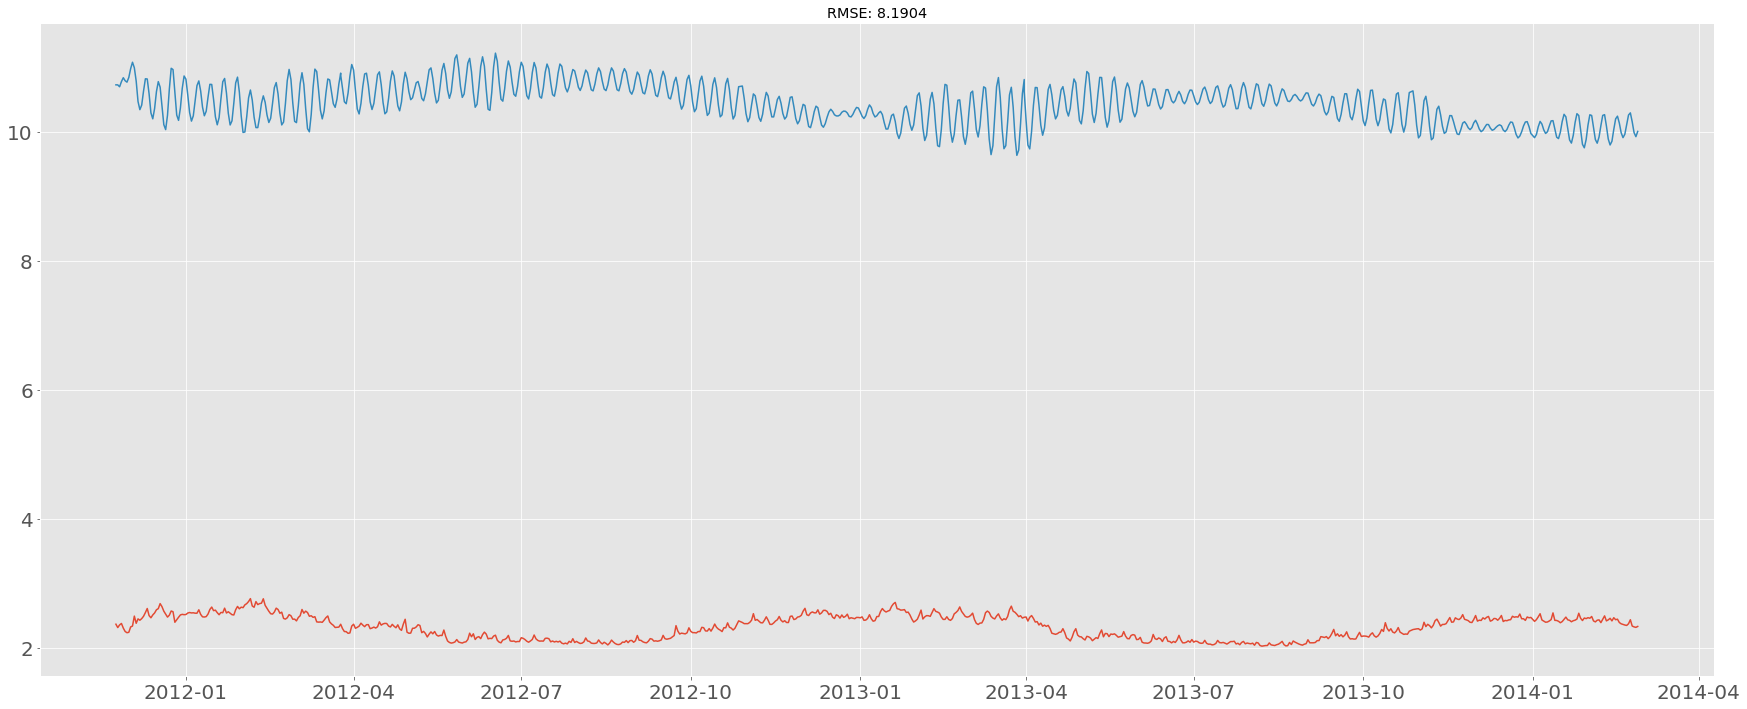

In [102]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_log)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_log)**2)/len(ts_log)))

In [103]:
size = int(len(ts_log) - 15)
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

In [104]:
size = int(len(ts_log) - 15)
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...




/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=10.300081, expected=10.362517


In [105]:
error = mean_squared_error(test, predictions)
print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index = test.index)



Printing Mean Squared Error of Predictions...
Test MSE: 0.001233


# Future Forecasting Using ARIMA Model

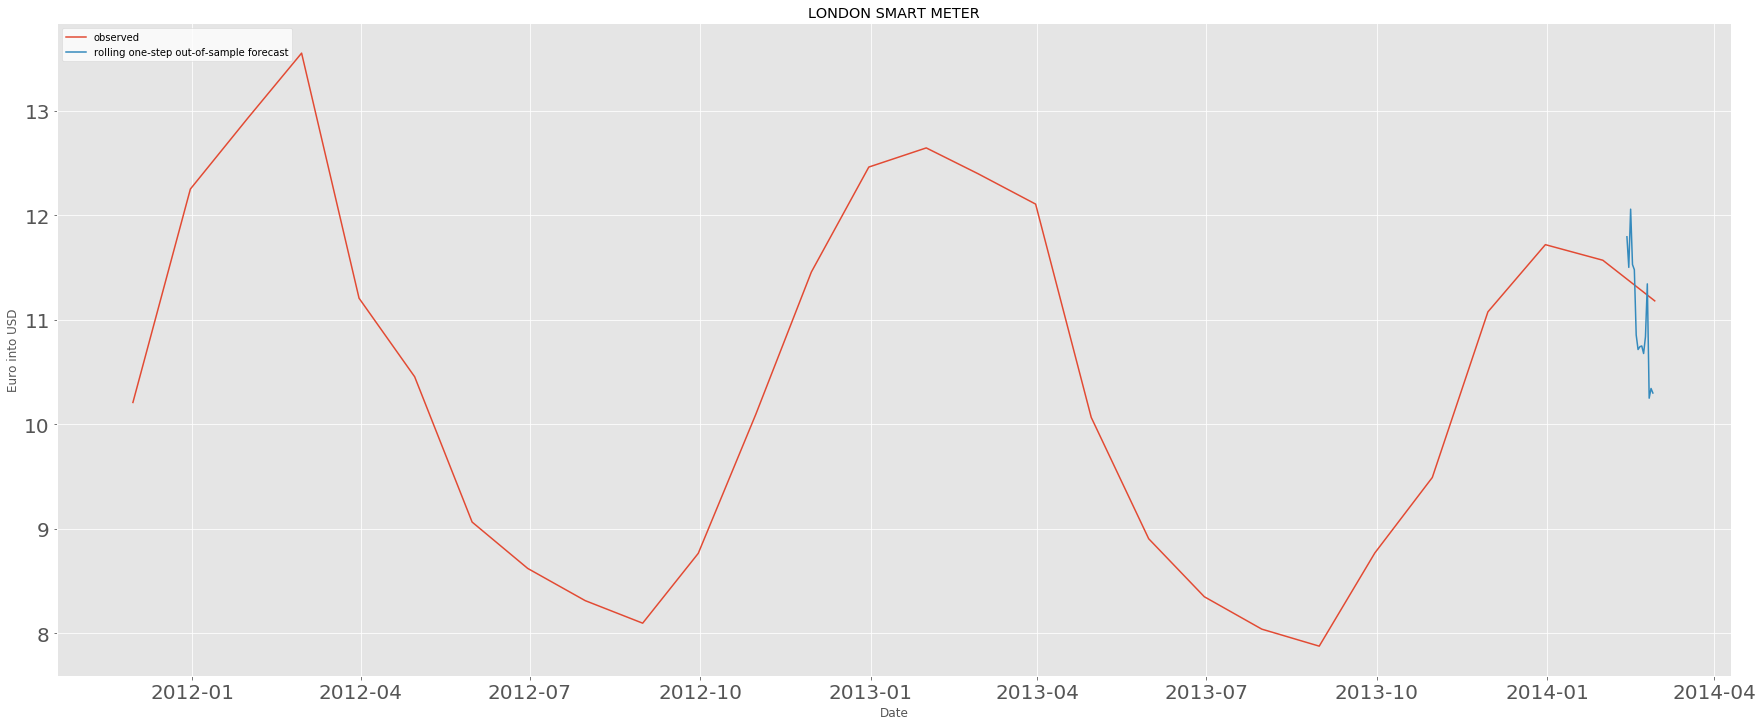

In [106]:
fig, ax = plt.subplots()
ax.set(title='LONDON SMART METER', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_month_mean[-60:], '-', label='observed')
ax.plot(np.exp(predictions_series), '',label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [107]:
from pandas.plotting import autocorrelation_plot

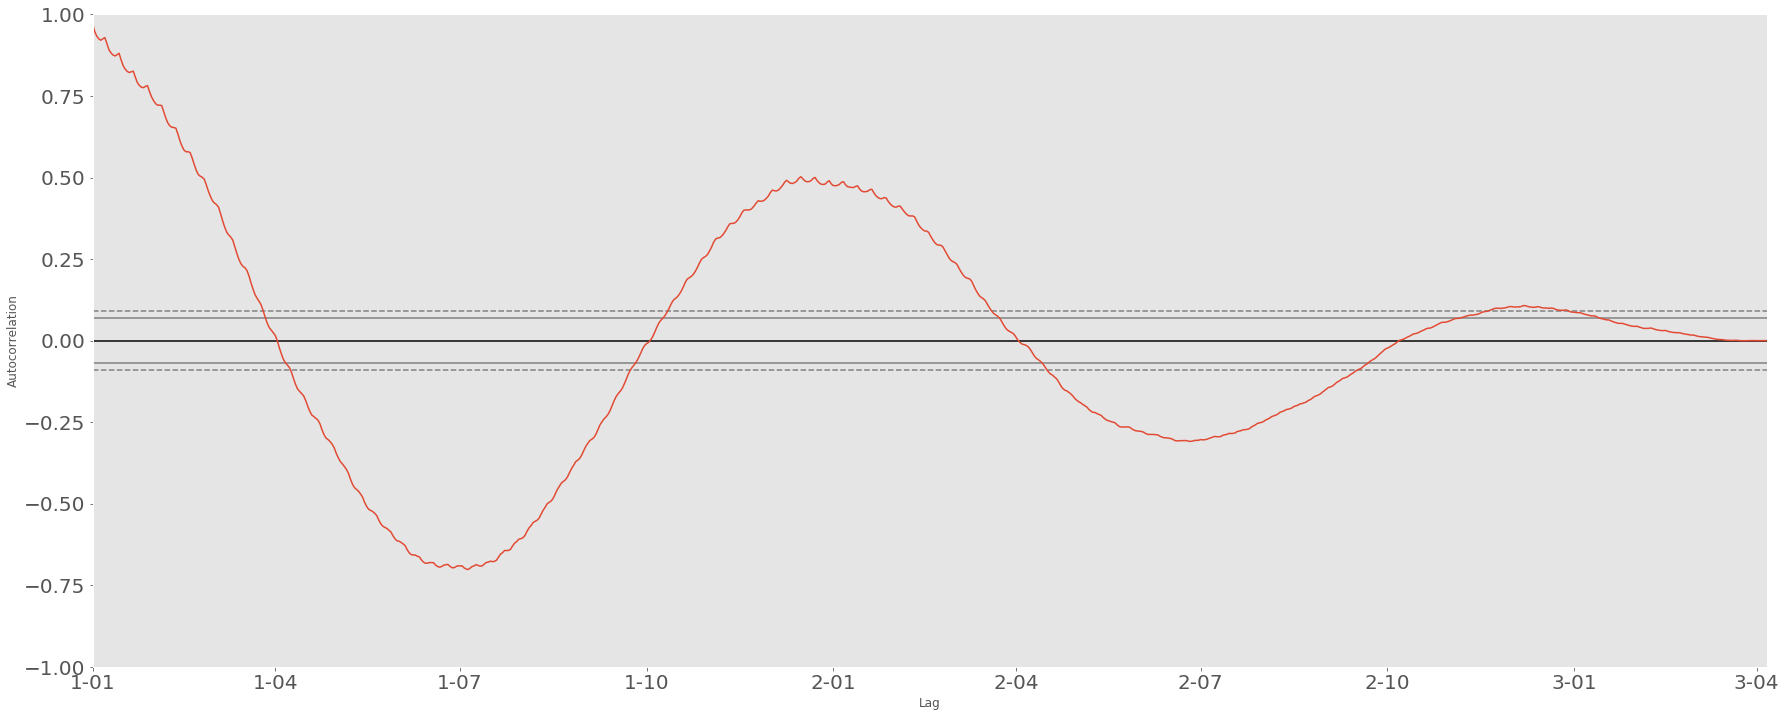

In [108]:
autocorrelation_plot(ts_log)
plt.plot(ts_log)

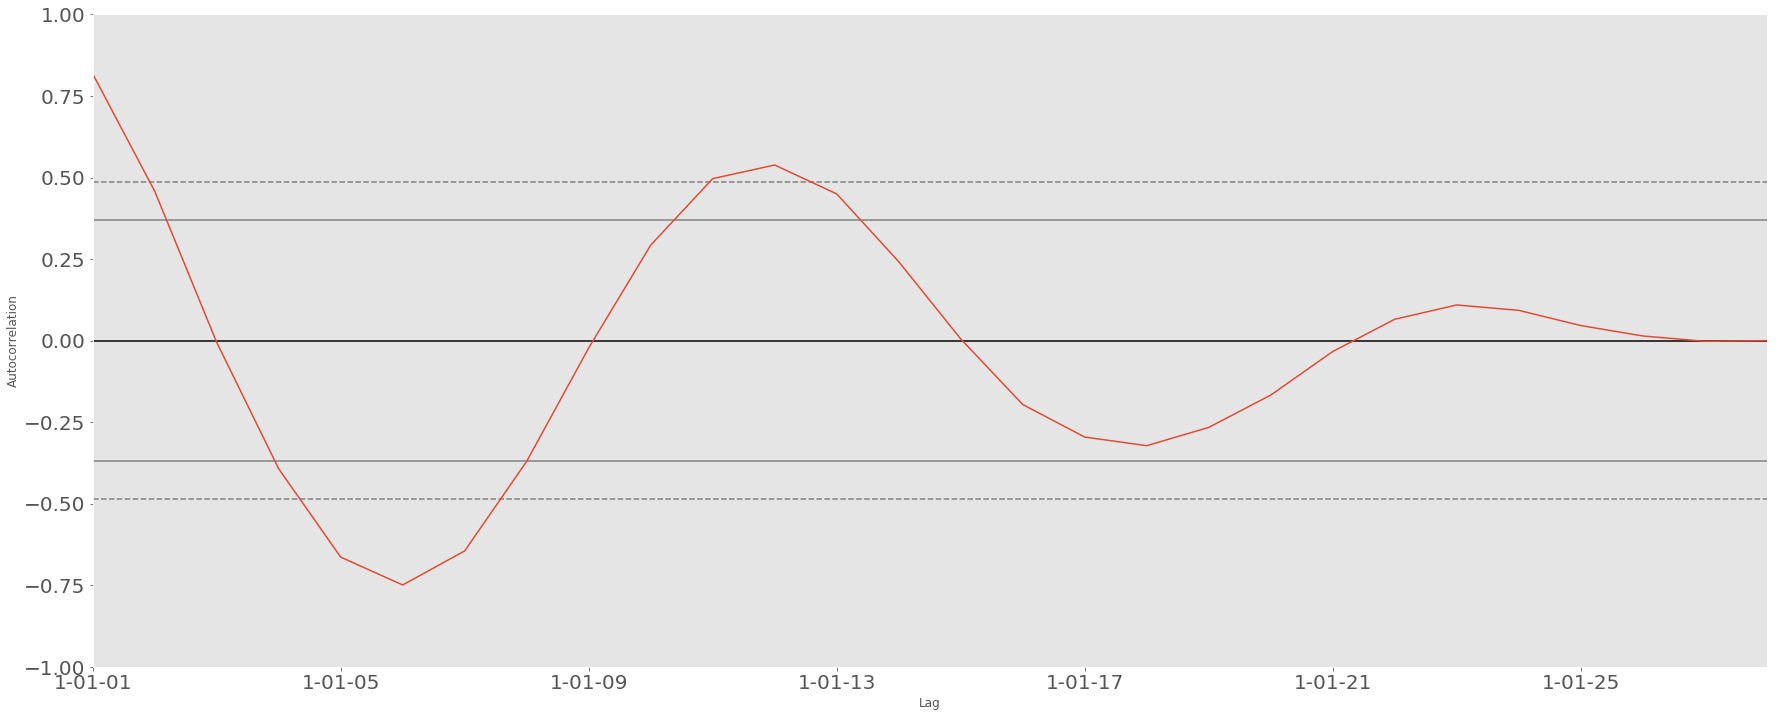

In [109]:
autocorrelation_plot(ts_month_mean)
plt.plot(ts_month_mean)

In [110]:
timeseries = arima_df["avg_energy"]
timeseries.head()

day
2011-11-24    10.728615
2011-11-25    10.182200
2011-11-26    10.610687
2011-11-27    10.850805
2011-11-28    10.105561
Name: avg_energy, dtype: float64